**Описание проекта:** Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.  
Имеется несколько задач: 
- Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
- Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.


**Цель исследования:** Провести анализ сотрудников в компании «Работа с заботой». Обучить и выбрать лучшие модели для задач регресиии и классификации.

**Ход исследования:**
- загрузка и предобработка данных: загрузка и первоначальный осмотр датасетов. преобразование датафреймов по необходимости
- исследовательский анализ данных
- подготовка данных с помощью пайплайна и обучение моделей:<br>
для регрессии: LinearRegression, SVR, RandomForestRegressor, DecisionTreeRegressor<br>
для классификации: SVC, KneighborsClassifier, RandomForestClassifier
- анализ важности признаков для лучших моделей
- вывод и рекомендации заказчику


**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций.


In [1]:
%pip install scikit-learn -q -U 
%pip install optuna-integration[sklearn] -q
%pip install phik -q
%pip install shap -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import phik
import shap

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder,
    LabelEncoder,
    MinMaxScaler,
    StandardScaler,
    RobustScaler
)

from sklearn.metrics import make_scorer, roc_auc_score

from optuna.integration import OptunaSearchCV
from optuna import distributions

#импортируем модели
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
warnings.filterwarnings('ignore')

## Задача 1. Предсказание уровня удовлетворённости сотрудника

### 1-2. Загрузка и предобработка данных.

#### 1-2.1 train_job_satisfaction_rate

In [5]:
train_job_satisfaction_rate = pd.read_csv(r'../datasets/train_job_satisfaction_rate_fixed.csv')
train_job_satisfaction_rate.info()
display(train_job_satisfaction_rate.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [6]:
train_job_satisfaction_rate.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


Можем заметить, что 75% данных по зарплате укладывается до 43 200, а максимальное значение 98 400, что говорит о том, что в данных есть маленькое количество данных с высоким значением относительно остальных данных по salary.

In [7]:
pd.DataFrame(round(train_job_satisfaction_rate.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
id,0.000000
dept,0.200000
level,0.100000
workload,0.000000
employment_years,0.000000
last_year_promo,0.000000
last_year_violations,0.000000
supervisor_evaluation,0.000000
salary,0.000000
job_satisfaction_rate,0.000000


В сумме количество пропусков в процентах составляет 0,3% от всех наблюдений. Мы их заполним с помощью пайплайна.

In [8]:
print(f'Кол-во явных дубликатов равно: {train_job_satisfaction_rate.duplicated().sum()}')

Кол-во явных дубликатов равно: 0


In [9]:
for i in train_job_satisfaction_rate.drop('id', axis=1).columns:
    dups = train_job_satisfaction_rate[train_job_satisfaction_rate[['id', i]].duplicated(keep=False)]
    if len(dups) > 0:
        display(dups)

In [10]:
for i in train_job_satisfaction_rate.select_dtypes(exclude='number').columns:
    print(f"{i}: {train_job_satisfaction_rate[i].unique()}")

dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level: ['junior' 'middle' 'senior' nan]
workload: ['medium' 'high' 'low']
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']


In [11]:
train_job_satisfaction_rate['level'] = train_job_satisfaction_rate['level'].str.replace('sinior', 'senior', regex=True)

Неявные дубликаты не были найдены. Но была найдена и исправлена опечатка

In [12]:
train_job_satisfaction_rate['supervisor_evaluation'].unique()

array([1, 5, 2, 3, 4], dtype=int64)

In [13]:
train_job_satisfaction_rate['supervisor_evaluation'] = train_job_satisfaction_rate['supervisor_evaluation'].astype('object')

In [14]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   object 
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 312.6+ KB


#### 1-2.2 full_test_features

In [15]:
test_features = pd.read_csv(r'../datasets/test_features.csv')
test_target_job_satisfaction_rate = pd.read_csv(r'../datasets/test_target_job_satisfaction_rate.csv')
full_test_features = test_features.merge(test_target_job_satisfaction_rate, on='id', how='left')
full_test_features.info()
display(full_test_features.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


In [16]:
full_test_features.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000
mean,552765.213500,3.666500,3.526500,34066.800000,0.54878
std,253851.326129,2.537222,0.996892,15398.436729,0.22011
min,100298.000000,1.000000,1.000000,12000.000000,0.03000
25%,339052.000000,1.000000,3.000000,22800.000000,0.38000
50%,550793.000000,3.000000,4.000000,30000.000000,0.58000
75%,765763.750000,6.000000,4.000000,43200.000000,0.72000
max,999029.000000,10.000000,5.000000,96000.000000,1.00000


In [17]:
pd.DataFrame(round(full_test_features.isna().mean()*100,3)).style.background_gradient('coolwarm')

,0
id,0.000000
dept,0.100000
level,0.050000
workload,0.000000
employment_years,0.000000
last_year_promo,0.000000
last_year_violations,0.000000
supervisor_evaluation,0.000000
salary,0.000000
job_satisfaction_rate,0.000000


In [18]:
print(f'Кол-во явных дубликатов равно: {full_test_features.duplicated().sum()}')

Кол-во явных дубликатов равно: 0


In [19]:
for i in full_test_features.select_dtypes(exclude='number').columns:
    print(f"{i}: {full_test_features[i].unique()}")

dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level: ['junior' 'middle' 'sinior' nan]
workload: ['medium' 'low' 'high' ' ']
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']


In [20]:
full_test_features['level'] = full_test_features['level'].str.replace('sinior', 'senior', regex=True)

In [21]:
print(len(full_test_features[full_test_features['dept'] == ' ']))
print(len(full_test_features[full_test_features['workload'] == ' ']))

1
1


Кроме nan видим по одой строчке с пробелом вместо значений, обработаем также этот момент

In [22]:
full_test_features['supervisor_evaluation'] = full_test_features['supervisor_evaluation'].astype('object')

In [23]:
full_test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   object 
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 171.9+ KB


Были загружены и проделана предобработка данных. Проверены данные на дубликаты и пропуски. Пропуски мы уберем с помощью пайплайна в разделе подготовки данных. Изменнен тип данных некоторых фичей и также небольшой анализ датасетов с помощью describe

### 3. Исследовательский анализ данных.

#### 3.1 Анализ датасета train_job_satisfaction_rate

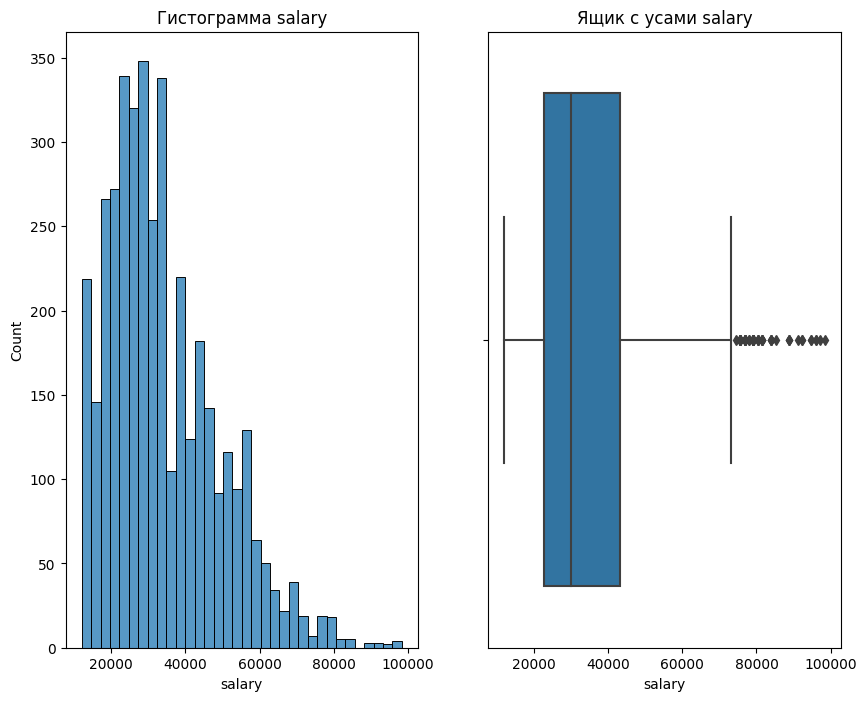

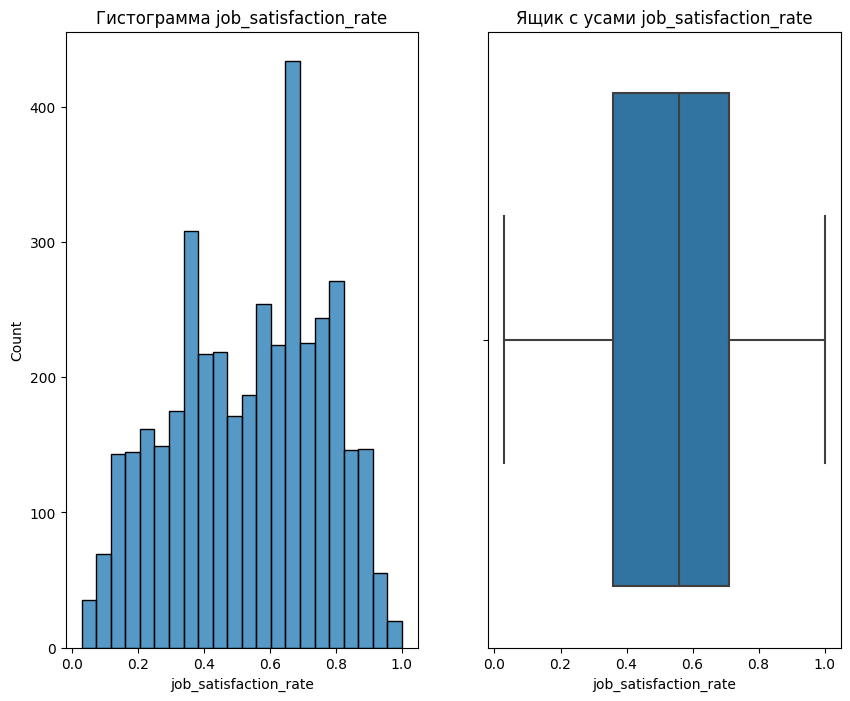

In [24]:
for i in train_job_satisfaction_rate.drop(['id', 'employment_years'], axis=1).select_dtypes(include='number').columns:
    fig, axes = plt.subplots(1, 2, figsize=(10, 8))
    sns.histplot(data=train_job_satisfaction_rate, x=i, ax=axes[0])
    axes[0].set_title(f'Гистограмма {i}')
    sns.boxplot(data=train_job_satisfaction_rate, x=i, ax=axes[1])
    axes[1].set_title(f'Ящик с усами {i}')

На графике salary можем наблюдать выбросы, на которые мы уже обратили внимание на этапе загрузки и предобработки данных.
Рейтинг удовлетворения работой имеет бимодальное распределние без выбросов

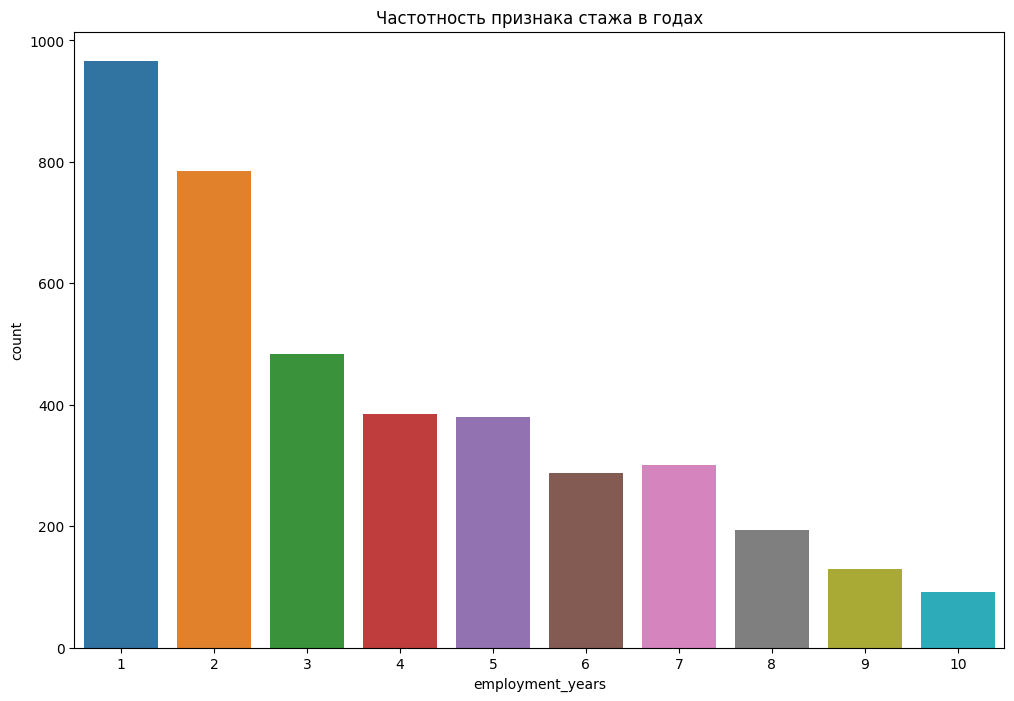

In [25]:
plt.figure(figsize=(12, 8))
sns.countplot(data=train_job_satisfaction_rate, x='employment_years');
plt.title('Частотность признака стажа в годах')
plt.show()

В рассматриваемых тренировочных данных преобладает стаж 1 и 2 года

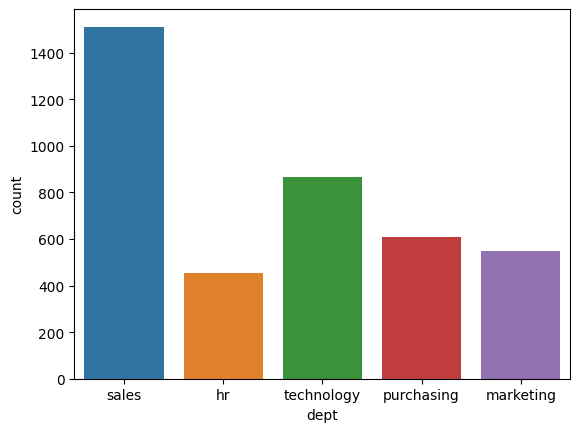

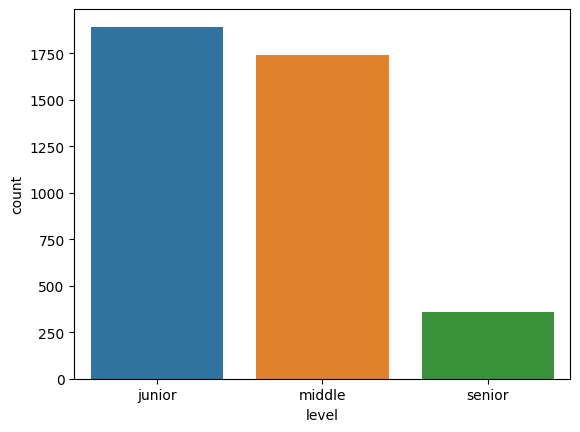

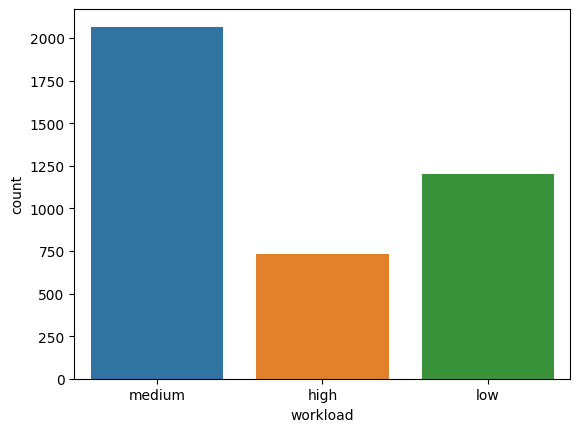

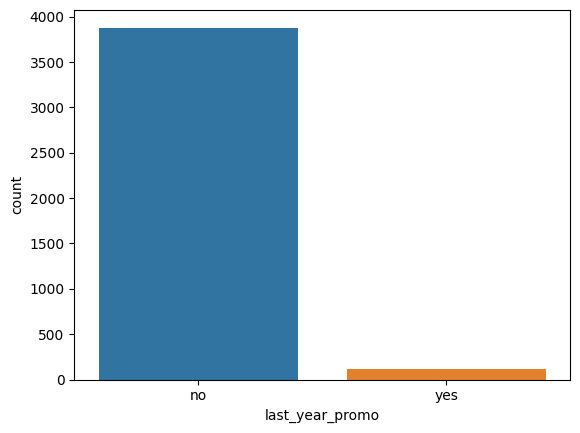

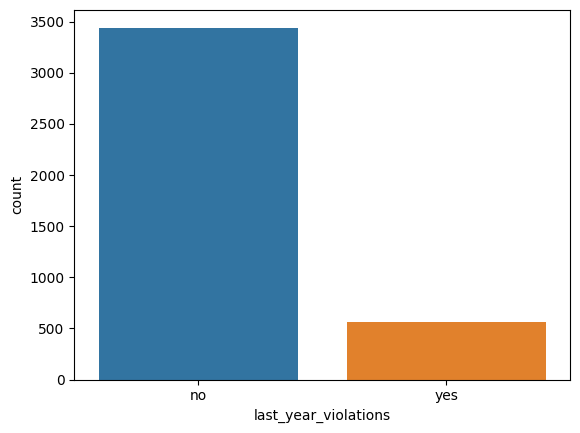

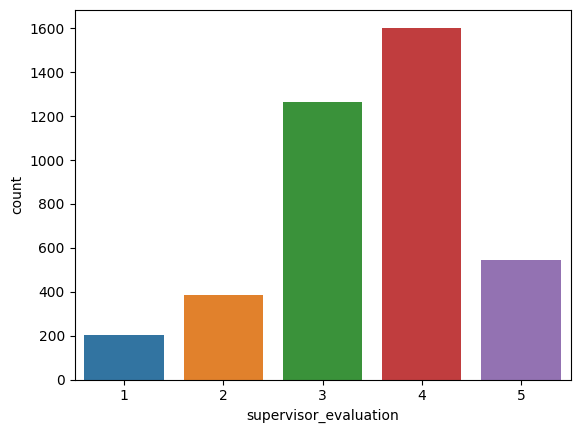

In [26]:
for i in train_job_satisfaction_rate.select_dtypes(exclude='number').columns:
    sns.countplot(data=train_job_satisfaction_rate, x=i)
    plt.show()

Что бросается сразу в глаза, так это такие признаки как: было ли повышение в прошлом году и нарушал ли работник трудовой договор. Категории 'yes' в разы меньше.

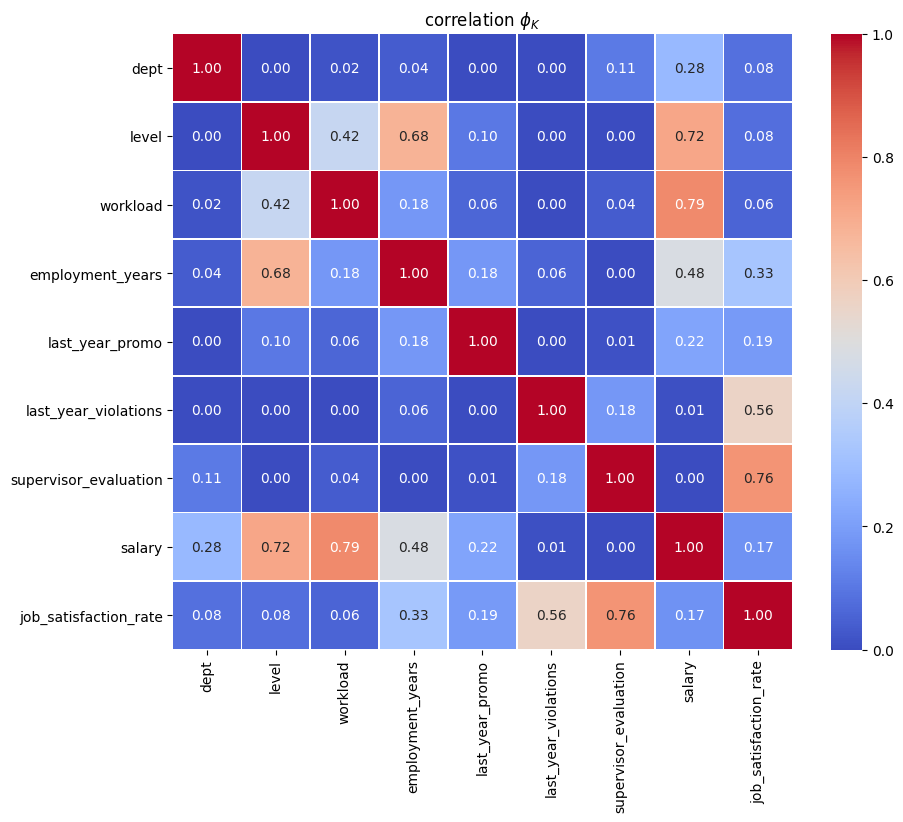

In [27]:
interval_cols = train_job_satisfaction_rate.drop('id', axis=1).select_dtypes(include='number').columns.to_list()

plt.figure(figsize=(10, 8))
sns.heatmap(train_job_satisfaction_rate.drop('id', axis=1).phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5);

plt.title(r"correlation $\phi_K$")
plt.show()

#### 3.2. Анализ датасета full_test_features

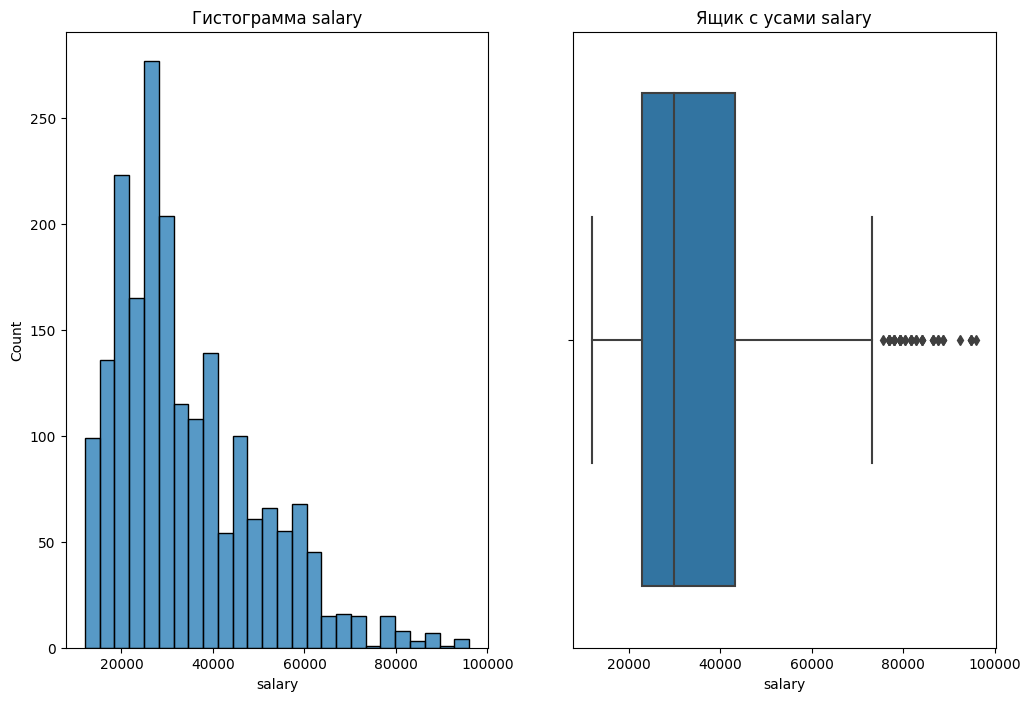

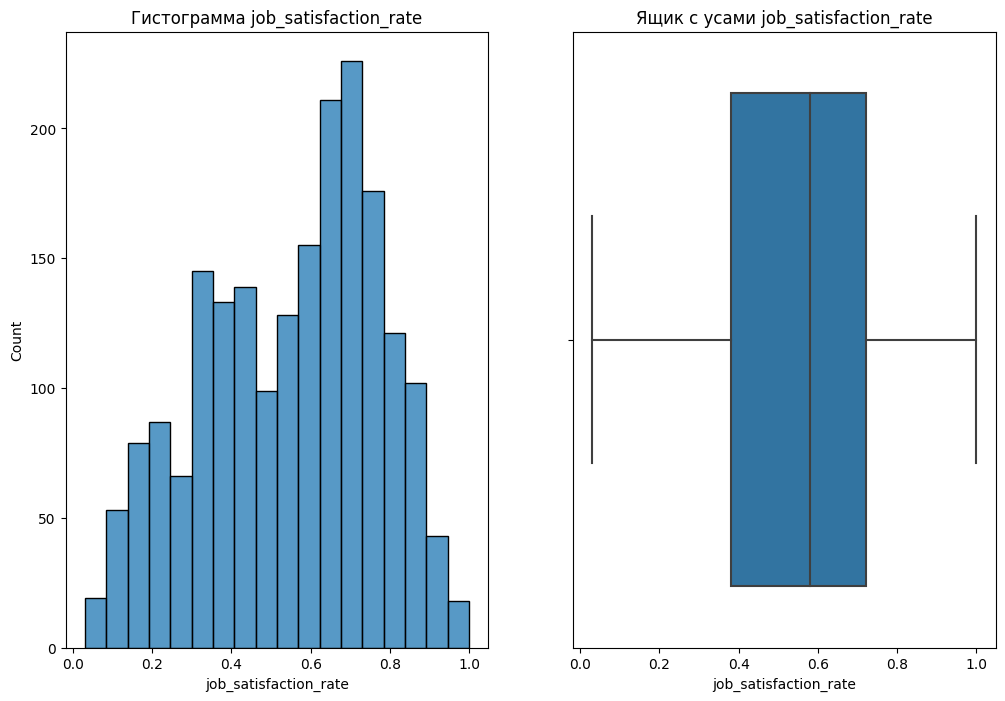

In [28]:
for i in full_test_features.drop(['id', 'employment_years'], axis=1).select_dtypes(include='number').columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))
    sns.histplot(data=full_test_features, x=i, ax=axes[0])
    axes[0].set_title(f'Гистограмма {i}')
    sns.boxplot(data=full_test_features, x=i, ax=axes[1])
    axes[1].set_title(f'Ящик с усами {i}')

Картина похожа на графики из тренировочных данных.

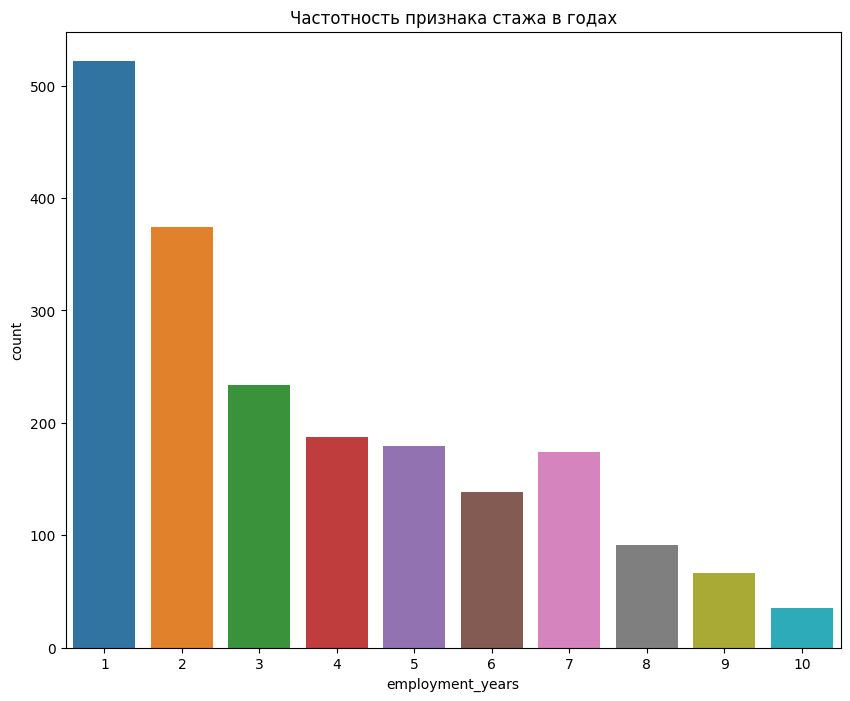

In [29]:
plt.figure(figsize=(10, 8))
sns.countplot(data=full_test_features, x='employment_years');
plt.title('Частотность признака стажа в годах')
plt.show()

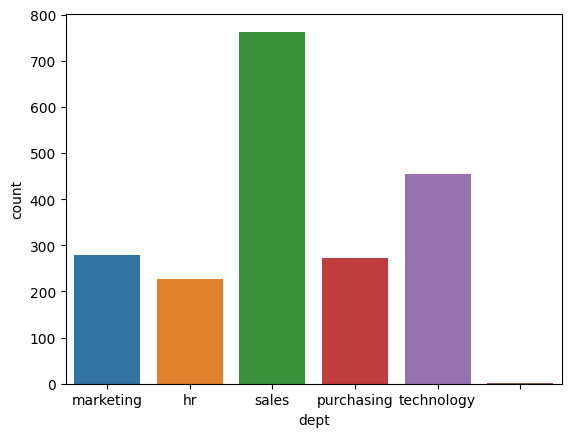

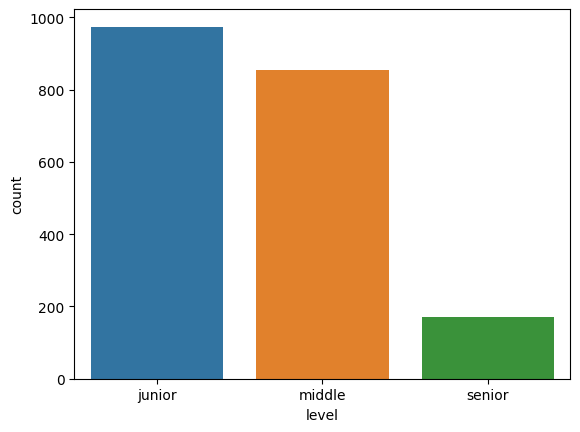

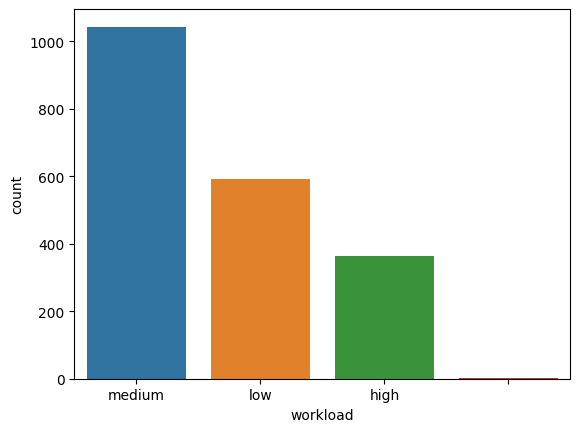

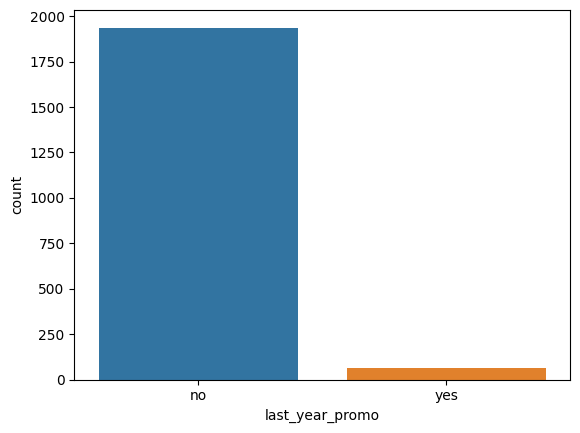

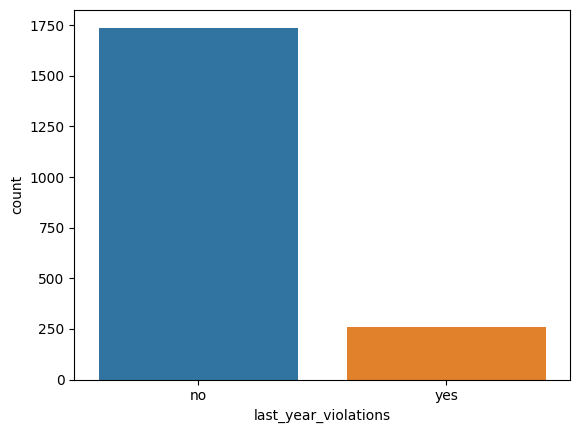

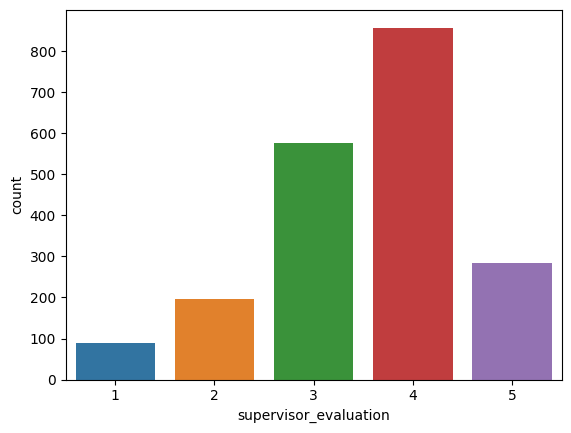

In [30]:
for i in full_test_features.select_dtypes(exclude='number').columns:
    sns.countplot(data=full_test_features, x=i)
    plt.show()

Картина не сильно отличается от тренировочных данных. Единственное добавилось значение ' ', но с ним мы разберемся в разделе подготовки данных.

В первой задаче нам нужно обучить линейную модель, а для линейной модели очень важна размерность числовых признаков, поэтому нужно масштабировать числовые признаки. Также для категориальных признаков, где нет ранга использовать OHE, вместо Ordinal.
<br>Для дерева решений не принципиально масштабированы данные или нет. Также не обязательно кодировать в OHE, если есть не ранговые признаки.

### 4. Подготовка данных и обучение моделей

In [31]:
train_job_satisfaction_rate.set_index('id', inplace=True)
full_test_features.set_index('id', inplace=True)

In [32]:
print(f'Кол-во явных дубликатов в датафрейме train_job_satisfaction_rate после изменения датафрема: {train_job_satisfaction_rate.duplicated().sum()}')
print(f'Кол-во явных дубликатов в датафрейме full_test_features после изменения датафрема: {full_test_features.duplicated().sum()}')

train_job_satisfaction_rate = train_job_satisfaction_rate.drop_duplicates()

Кол-во явных дубликатов в датафрейме train_job_satisfaction_rate после изменения датафрема: 245
Кол-во явных дубликатов в датафрейме full_test_features после изменения датафрема: 83


In [33]:
X_train, y_train = train_job_satisfaction_rate.drop('job_satisfaction_rate', axis=1), train_job_satisfaction_rate['job_satisfaction_rate']
X_test, y_test = full_test_features.drop('job_satisfaction_rate', axis=1), full_test_features['job_satisfaction_rate']

In [34]:
def smape_score(y_true, y_pred):
    '''
    англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение». Принимает истинные и предсказанные значения. Возвращает метрику
    '''
    smape = (100 / len(y_true)) * np.sum(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))
    return smape

scorer = make_scorer(smape_score, greater_is_better=False)

#### 4.1 LinearRegression

In [35]:
ohe_pipe_linear = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 


#создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
ord_pipe_linear = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(handle_unknown='use_encoded_value',
                           categories=[
                               ['junior', 'middle', 'senior'],
                               ['low', 'medium', 'high'],
                               [1, 2, 3, 4, 5]
                           ],
                           unknown_value=np.nan)
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [36]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload', 'supervisor_evaluation']
num_columns = X_train.select_dtypes(include='number').columns.to_list()

data_preprocessor_linear = ColumnTransformer(
    [
        ('ohe', ohe_pipe_linear, ohe_columns),
        ('ord', ord_pipe_linear, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final_linear = Pipeline(
    [
        ('preprocessor', data_preprocessor_linear),
        ('models', LinearRegression(n_jobs=-1))
    ]
)    
    
    
param_grid_linear = {
    'preprocessor__num': distributions.CategoricalDistribution([
        MinMaxScaler(), 
        StandardScaler(), 
        RobustScaler(),
        'passthrough'
    ])
}

In [37]:
%%time

oscv = OptunaSearchCV(
    pipe_final_linear,
    param_grid_linear,
    cv=5,
    scoring=scorer,
    n_trials=10,
    random_state=RANDOM_STATE
).fit(X_train, y_train)


print(f'Лучшая метрика: {-1 * oscv.best_score_}')
print(f'Лучшие параметры: {oscv.best_params_}')
print(f'Лучшая модель: {oscv.best_estimator_}')

[I 2025-06-13 18:49:36,405] A new study created in memory with name: no-name-19e19c59-5ede-4c9d-be41-ca9359c168fe
[I 2025-06-13 18:49:36,599] Trial 0 finished with value: -25.005621272180882 and parameters: {'preprocessor__num': StandardScaler()}. Best is trial 0 with value: -25.005621272180882.
[I 2025-06-13 18:49:36,777] Trial 1 finished with value: -25.005621272180875 and parameters: {'preprocessor__num': MinMaxScaler()}. Best is trial 1 with value: -25.005621272180875.
[I 2025-06-13 18:49:36,935] Trial 2 finished with value: -25.00562127218092 and parameters: {'preprocessor__num': 'passthrough'}. Best is trial 1 with value: -25.005621272180875.
[I 2025-06-13 18:49:37,115] Trial 3 finished with value: -25.005621272180875 and parameters: {'preprocessor__num': MinMaxScaler()}. Best is trial 1 with value: -25.005621272180875.
[I 2025-06-13 18:49:37,291] Trial 4 finished with value: -25.005621272180882 and parameters: {'preprocessor__num': StandardScaler()}. Best is trial 1 with value: 

Лучшая метрика: 25.005621272180875
Лучшие параметры: {'preprocessor__num': MinMaxScaler()}
Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
           

In [38]:
metric_linear = scorer(
    oscv.best_estimator_,  # type: ignore
    X_test, 
    y_test
)
print(f'Метрика SMAPE на тестовой выборке моделью LinearRegression равна {-1 * metric_linear}')

Метрика SMAPE на тестовой выборке моделью LinearRegression равна 23.56569625201928


#### 4.2 SVR

In [39]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload', 'supervisor_evaluation']
num_columns = X_train.select_dtypes(include='number').columns.to_list()

data_preprocessor_linear = ColumnTransformer(
    [
        ('ohe', ohe_pipe_linear, ohe_columns),
        ('ord', ord_pipe_linear, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final_linear_svr = Pipeline(
    [
        ('preprocessor', data_preprocessor_linear),
        ('models', SVR(kernel='linear', C=1))
    ]
)    
    
    
param_grid_linear_svr = {
    'models__C': distributions.FloatDistribution(1, 6, step=0.5),
    'preprocessor__num': distributions.CategoricalDistribution([
        MinMaxScaler(), 
        StandardScaler(), 
        RobustScaler(),
    ])
}


pipe_final_non_linear_svr = Pipeline(
    [
        ('preprocessor', data_preprocessor_linear),
        ('models', SVR(kernel='rbf', C=1))
    ]
)

param_grid_rbf_sigmoid_svr = {
    'models__kernel': distributions.CategoricalDistribution(['sigmoid', 'rbf']),
    'models__gamma': distributions.CategoricalDistribution(['scale', 'auto']),
    'models__C': distributions.IntDistribution(1, 30),
    'preprocessor__num': distributions.CategoricalDistribution([
        MinMaxScaler(), 
        StandardScaler(), 
        RobustScaler(),
    ])
}

In [40]:
%%time

oscv_linear_svr = OptunaSearchCV(
    pipe_final_linear_svr,
    param_grid_linear_svr,
    cv=5,
    scoring=scorer,
    n_trials=20,
    verbose=2,
    random_state=RANDOM_STATE
).fit(X_train, y_train)

print(f'Лучшая метрика: {-1 * oscv_linear_svr.best_score_}')

[I 2025-06-13 18:49:38,637] A new study created in memory with name: no-name-10a92978-0253-4341-850c-0244aec576ba
[I 2025-06-13 18:49:44,439] Trial 0 finished with value: -24.982227323139803 and parameters: {'models__C': 3.5, 'preprocessor__num': MinMaxScaler()}. Best is trial 0 with value: -24.982227323139803.
[I 2025-06-13 18:49:50,215] Trial 1 finished with value: -24.982227323139803 and parameters: {'models__C': 3.5, 'preprocessor__num': MinMaxScaler()}. Best is trial 0 with value: -24.982227323139803.
[I 2025-06-13 18:49:54,268] Trial 2 finished with value: -24.98174815140566 and parameters: {'models__C': 1.5, 'preprocessor__num': RobustScaler()}. Best is trial 2 with value: -24.98174815140566.
[I 2025-06-13 18:50:01,466] Trial 3 finished with value: -24.986424540272555 and parameters: {'models__C': 3.5, 'preprocessor__num': RobustScaler()}. Best is trial 2 with value: -24.98174815140566.
[I 2025-06-13 18:50:09,271] Trial 4 finished with value: -24.98277352619548 and parameters: {

Лучшая метрика: 24.97614132004054
CPU times: total: 1min 51s
Wall time: 1min 52s


In [41]:
print(f'Метрика SMAPE модели SVR на тестовой выборке равна: {-1 * scorer(oscv_linear_svr.best_estimator_, X_test, y_test)}') # type: ignore

Метрика SMAPE модели SVR на тестовой выборке равна: 23.55344224390763


In [42]:
%%time

oscv_rbf_sigmoid_svr = OptunaSearchCV(
    pipe_final_non_linear_svr,
    param_grid_rbf_sigmoid_svr,
    cv=5,
    scoring=scorer,
    n_trials=20,
    verbose=2,
    random_state=RANDOM_STATE
).fit(X_train, y_train)

print(f'Лучшая метрика: {-1 * oscv_rbf_sigmoid_svr.best_score_}')
print(f'Лучшая модель: {oscv_rbf_sigmoid_svr.best_estimator_}')

[I 2025-06-13 18:51:31,363] A new study created in memory with name: no-name-27050d73-8154-47ee-aece-fa25cfdf5307
[I 2025-06-13 18:51:33,551] Trial 0 finished with value: -15.70125836455876 and parameters: {'models__kernel': 'rbf', 'models__gamma': 'auto', 'models__C': 15, 'preprocessor__num': MinMaxScaler()}. Best is trial 0 with value: -15.70125836455876.
[I 2025-06-13 18:51:36,113] Trial 1 finished with value: -15.319470562019731 and parameters: {'models__kernel': 'rbf', 'models__gamma': 'auto', 'models__C': 16, 'preprocessor__num': RobustScaler()}. Best is trial 1 with value: -15.319470562019731.
[I 2025-06-13 18:51:38,136] Trial 2 finished with value: -15.693285876935125 and parameters: {'models__kernel': 'rbf', 'models__gamma': 'auto', 'models__C': 14, 'preprocessor__num': MinMaxScaler()}. Best is trial 1 with value: -15.319470562019731.
[I 2025-06-13 18:51:39,529] Trial 3 finished with value: -15.672647411721593 and parameters: {'models__kernel': 'rbf', 'models__gamma': 'scale',

Лучшая метрика: 15.287788547732381
Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
          

In [43]:
print(f'Метрика SMAPE модели SVR на тестовой выборке равна: {-1 * scorer(oscv_rbf_sigmoid_svr.best_estimator_, X_test, y_test)}') # type: ignore

Метрика SMAPE модели SVR на тестовой выборке равна: 13.969013302558048


#### 4.3 RandomForestRegressor

In [44]:
ordered_pipe_rfr = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(handle_unknown='use_encoded_value',
                           categories=[
                               ['junior', 'middle', 'senior'],
                               ['low', 'medium', 'high'],
                               [1, 2, 3, 4, 5]
                           ],
                           unknown_value=np.nan)
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

unordered_pipe_rfr = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(handle_unknown='use_encoded_value',
                          unknown_value=np.nan)
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [45]:
ordered_features = ['level', 'workload', 'supervisor_evaluation']
unordered_features = ['dept', 'last_year_promo', 'last_year_violations']
num_features = X_train.select_dtypes(include='number').columns.to_list()

data_preprocessor_rfr = ColumnTransformer(
    [
        ('ord_ordered', ordered_pipe_rfr, ordered_features),
        ('ord_unordered', unordered_pipe_rfr, unordered_features),
        ('num', MinMaxScaler(), num_features),
    ],
    remainder='passthrough'
)

pipe_final_rfr = Pipeline(
    [
        ('preprocessor', data_preprocessor_rfr),
        ('models', RandomForestRegressor(random_state=RANDOM_STATE))
    ]
)    
    
    
param_grid_rfr = {
    'models__n_estimators': distributions.IntDistribution(100, 150),
    'models__max_depth': distributions.IntDistribution(1, 100),
    'models__min_samples_split': distributions.IntDistribution(2, 50),
    'models__min_samples_leaf': distributions.IntDistribution(1, 50),
    'preprocessor__num': distributions.CategoricalDistribution([
            MinMaxScaler(), 
            StandardScaler(), 
            RobustScaler()
        ])
}

In [46]:
%%time

oscv_rfr = OptunaSearchCV(
    pipe_final_rfr,
    param_grid_rfr,
    cv=5,
    scoring=scorer,
    n_trials=100,
    random_state=RANDOM_STATE,
).fit(X_train, y_train)

print(f'Лучшая метрика: {-1 * oscv_rfr.best_score_}')
print(f'Лучшие параметры: {oscv_rfr.best_params_}')

[I 2025-06-13 18:52:26,731] A new study created in memory with name: no-name-07a8e058-ec2a-4adf-85c9-dd48af79e157
[I 2025-06-13 18:52:28,828] Trial 0 finished with value: -17.01982633466739 and parameters: {'models__n_estimators': 123, 'models__max_depth': 84, 'models__min_samples_split': 5, 'models__min_samples_leaf': 16, 'preprocessor__num': MinMaxScaler()}. Best is trial 0 with value: -17.01982633466739.
[I 2025-06-13 18:52:30,649] Trial 1 finished with value: -17.29182965768677 and parameters: {'models__n_estimators': 108, 'models__max_depth': 18, 'models__min_samples_split': 17, 'models__min_samples_leaf': 18, 'preprocessor__num': MinMaxScaler()}. Best is trial 0 with value: -17.01982633466739.
[I 2025-06-13 18:52:32,279] Trial 2 finished with value: -20.129115932624494 and parameters: {'models__n_estimators': 119, 'models__max_depth': 48, 'models__min_samples_split': 43, 'models__min_samples_leaf': 49, 'preprocessor__num': StandardScaler()}. Best is trial 0 with value: -17.019826

Лучшая метрика: 13.892968213622254
Лучшие параметры: {'models__n_estimators': 137, 'models__max_depth': 84, 'models__min_samples_split': 4, 'models__min_samples_leaf': 2, 'preprocessor__num': StandardScaler()}
CPU times: total: 4min 22s
Wall time: 4min 26s


In [47]:
metric_rfr = scorer(oscv_rfr.best_estimator_, X_test, y_test) # type: ignore
print(f'SMAPE метрика на тестовой выборке {-1 * metric_rfr:.2f}')

SMAPE метрика на тестовой выборке 12.55


#### 4.4 DecisionTreeRegressor

In [48]:
ordered_features = ['level', 'workload', 'supervisor_evaluation']
unordered_features = ['dept', 'last_year_promo', 'last_year_violations']

data_preprocessor_rfr = ColumnTransformer(
    [
        ('ord_ordered', ordered_pipe_rfr, ordered_features),
        ('ord_unordered', unordered_pipe_rfr, unordered_features),
    ],
    remainder='passthrough'
)

pipe_final_dtr = Pipeline(
    [
        ('preprocessor', data_preprocessor_rfr),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)    
    
    
param_grid_dtr = {
    'models__max_depth': distributions.IntDistribution(1, 50),
    'models__min_samples_split': distributions.IntDistribution(2, 20),
    'models__min_samples_leaf': distributions.IntDistribution(1, 20),
    #'models__max_features': distributions.CategoricalDistribution(['auto', 'sqrt', 'log2', None]),
    'models__max_leaf_nodes': distributions.IntDistribution(10, 1000),
}

In [49]:
%%time

oscv_dtr = OptunaSearchCV(
    pipe_final_dtr,
    param_grid_dtr,
    cv=5,
    scoring=scorer,
    n_trials=100,
    random_state=RANDOM_STATE
).fit(X_train, y_train)

print('Лучшая метрика:', -1 * oscv_dtr.best_score_)

[I 2025-06-13 18:56:53,552] A new study created in memory with name: no-name-cd5cf271-b6db-48dc-9514-fbbdb3de22f5
[I 2025-06-13 18:56:53,748] Trial 0 finished with value: -15.27144094099429 and parameters: {'models__max_depth': 23, 'models__min_samples_split': 17, 'models__min_samples_leaf': 2, 'models__max_leaf_nodes': 326}. Best is trial 0 with value: -15.27144094099429.
[I 2025-06-13 18:56:53,950] Trial 1 finished with value: -15.224759660809246 and parameters: {'models__max_depth': 25, 'models__min_samples_split': 7, 'models__min_samples_leaf': 5, 'models__max_leaf_nodes': 175}. Best is trial 1 with value: -15.224759660809246.
[I 2025-06-13 18:56:54,130] Trial 2 finished with value: -16.774220729748514 and parameters: {'models__max_depth': 9, 'models__min_samples_split': 8, 'models__min_samples_leaf': 7, 'models__max_leaf_nodes': 1000}. Best is trial 1 with value: -15.224759660809246.
[I 2025-06-13 18:56:54,335] Trial 3 finished with value: -15.822722291666508 and parameters: {'mod

Лучшая метрика: 14.52071873710238
CPU times: total: 20.6 s
Wall time: 20.8 s


In [50]:
print("SMAPE на тестовой выборке", -1 * scorer(oscv_dtr.best_estimator_, X_test, y_test)) # type: ignore

SMAPE на тестовой выборке 13.41230113737147


Из всех моделей достигли метрики меньше равно 15: SVR с ядром rbf, RandomForestRegression и DecisionTreeRegressur.
Лучше всего показала себя модель RandomForestRegressor с метрикой SMAPE на тестовой выборке в 12.70

#### 5. Анализ важности признаков для лучшей модели

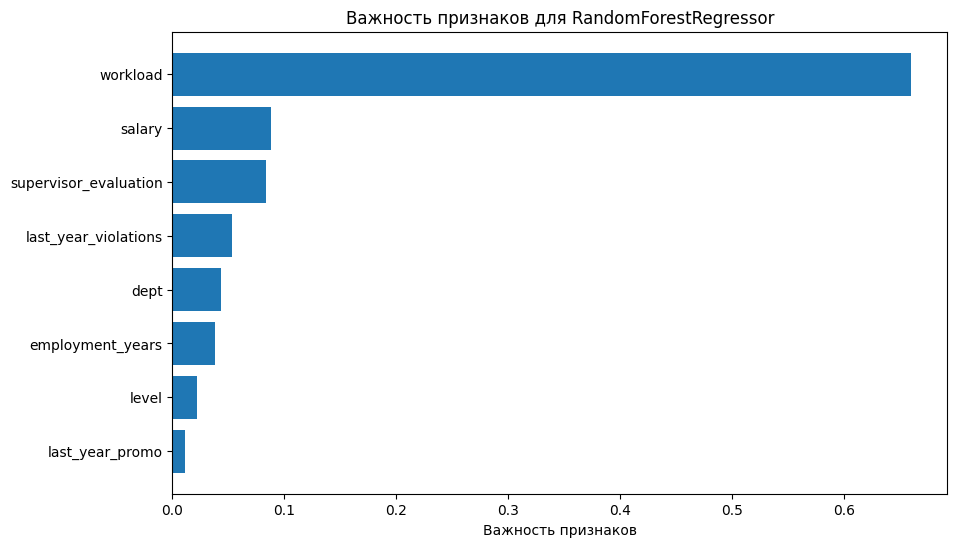

In [51]:
feature_importances = oscv_rfr.best_estimator_.named_steps['models'].feature_importances_ # type: ignore

# Сортировка признаков по убыванию важности
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_idx]
sorted_feature_names = np.array(X_train.columns)[sorted_idx]  # Названия отсортированных признаков

# Отрисовка графика
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances, align='center')
plt.xlabel('Важность признаков')
plt.title('Важность признаков для RandomForestRegressor')
plt.gca().invert_yaxis()  # Чтобы важнейшие признаки были сверху
plt.show()

Как мы видим из графика выше, наиболее важный признак для модели является загруженность работника. Далее идет зароботная плата и оценка проверяющего. Самым незначительным признаком модель определила было ли повышение в прошлом году.

## Задача 2. Предсказание увольнения сотрудника из компании

### 1-2. Загрузка и предобработка данных.

#### 1-2.1 train_quit

In [52]:
train_quit = pd.read_csv(r'../datasets/train_quit.csv')
train_quit.info()
display(train_quit.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [53]:
train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [54]:
pd.DataFrame(round(train_quit.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
id,0.000000
dept,0.000000
level,0.000000
workload,0.000000
employment_years,0.000000
last_year_promo,0.000000
last_year_violations,0.000000
supervisor_evaluation,0.000000
salary,0.000000
quit,0.000000


In [55]:
print(f'Кол-во явных дубликатов равно: {train_quit.duplicated().sum()}')

Кол-во явных дубликатов равно: 0


In [56]:
for i in train_quit.drop('id', axis=1).columns:
    dups = train_quit[train_quit[['id', i]].duplicated(keep=False)]
    if len(dups) > 0:
        display(dups)

In [57]:
for i in train_quit.select_dtypes(exclude='number').columns:
    print(f"{i}: {train_quit[i].unique()}")

dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level: ['middle' 'junior' 'sinior']
workload: ['high' 'medium' 'low']
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']
quit: ['no' 'yes']


In [58]:
train_quit['level'] = train_quit['level'].str.replace('sinior', 'senior', regex=True)

In [59]:
train_quit['supervisor_evaluation'] = train_quit['supervisor_evaluation'].astype('object')

In [60]:
train_quit.set_index('id', inplace=True)

In [61]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   object
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(2), object(7)
memory usage: 312.5+ KB


#### 1-2.2 test_target и full_test_features

In [62]:
test_target = pd.read_csv(r'../datasets/test_target_quit.csv')
test_target.info()
display(test_target.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [63]:
full_test_features = full_test_features.merge(test_target, on='id', how='left')
full_test_features.set_index('id', inplace=True)

In [64]:
full_test_features.info()
display(full_test_features.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1998 non-null   object 
 1   level                  1999 non-null   object 
 2   workload               2000 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   object 
 7   salary                 2000 non-null   int64  
 8   job_satisfaction_rate  2000 non-null   float64
 9   quit                   2000 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 171.9+ KB


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
686555,hr,junior,medium,1,no,no,4,30000,0.72,no
467458,sales,middle,low,5,no,no,4,19200,0.64,no
418655,sales,middle,low,6,no,no,4,19200,0.60,no
789145,hr,middle,medium,5,no,no,5,40800,0.75,no


### 3. Исследовательский анализ данных

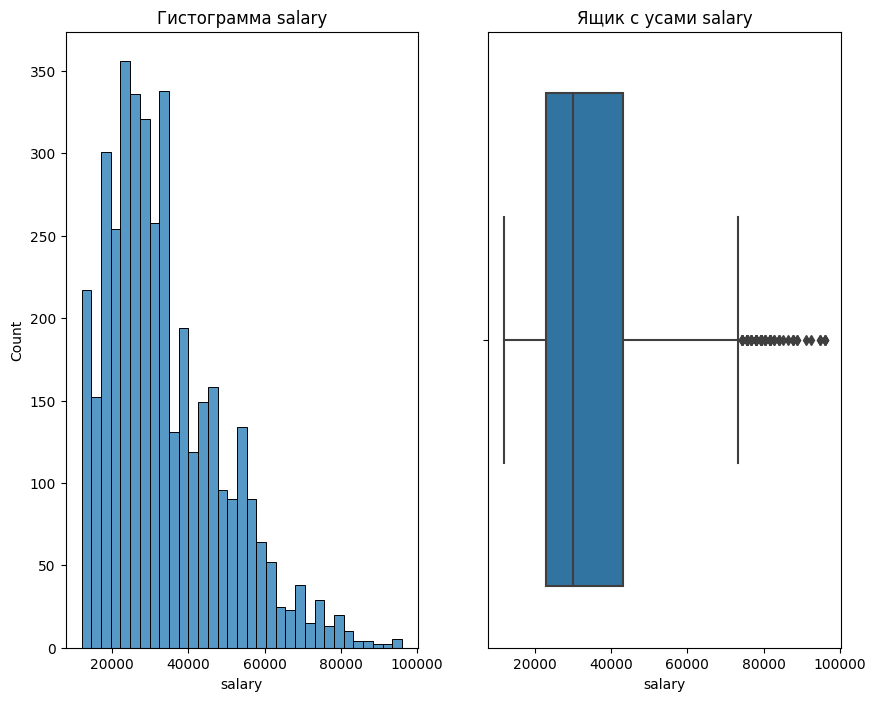

In [65]:
for i in train_quit.drop(['employment_years'], axis=1).select_dtypes(include='number').columns:
    fig, axes = plt.subplots(1, 2, figsize=(10, 8))
    sns.histplot(data=train_quit, x=i, ax=axes[0])
    axes[0].set_title(f'Гистограмма {i}')
    sns.boxplot(data=train_quit, x=i, ax=axes[1])
    axes[1].set_title(f'Ящик с усами {i}')
    plt.show()

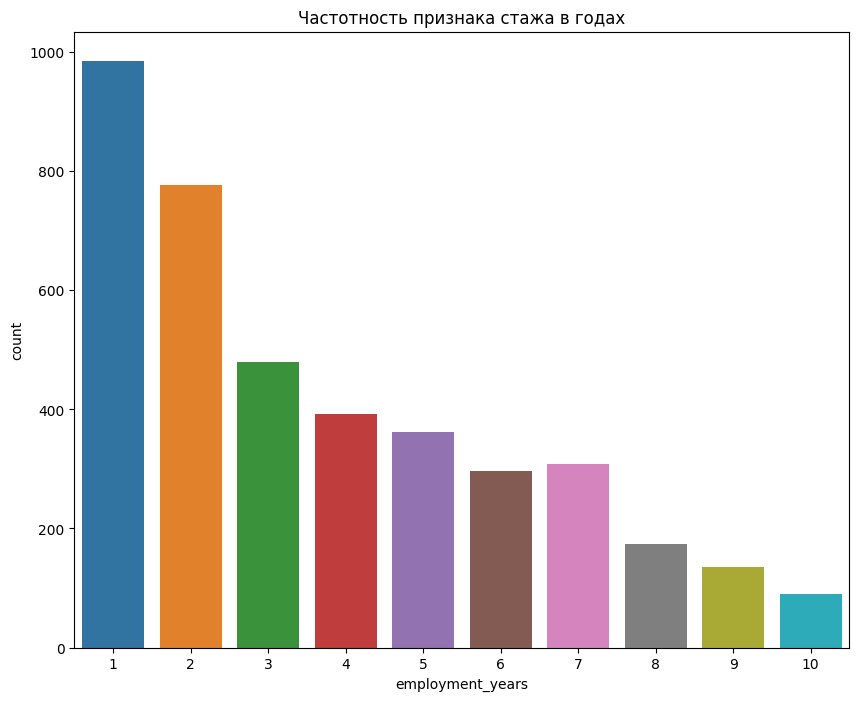

In [66]:
plt.figure(figsize=(10, 8))
sns.countplot(data=train_quit, x='employment_years');
plt.title('Частотность признака стажа в годах')
plt.show()

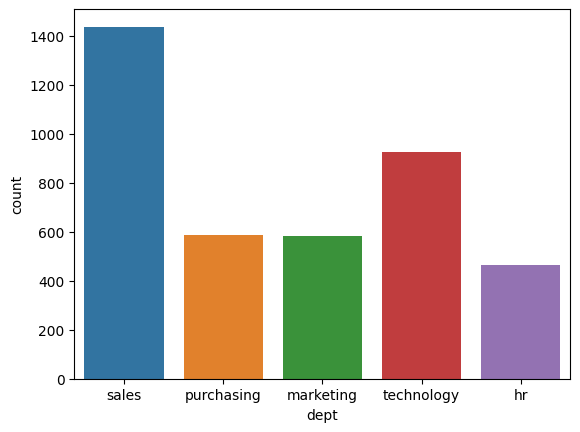

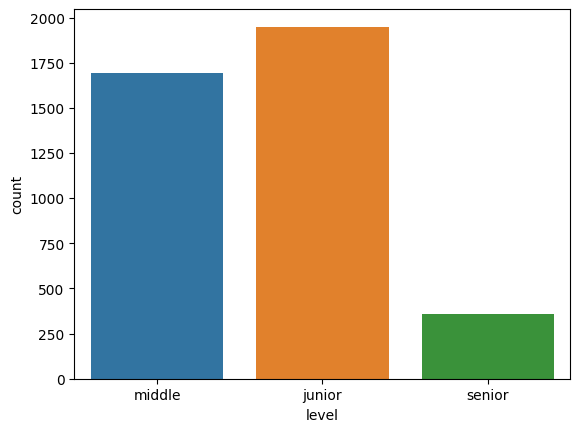

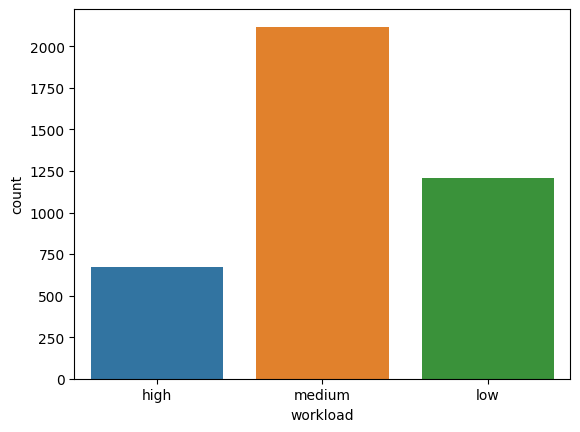

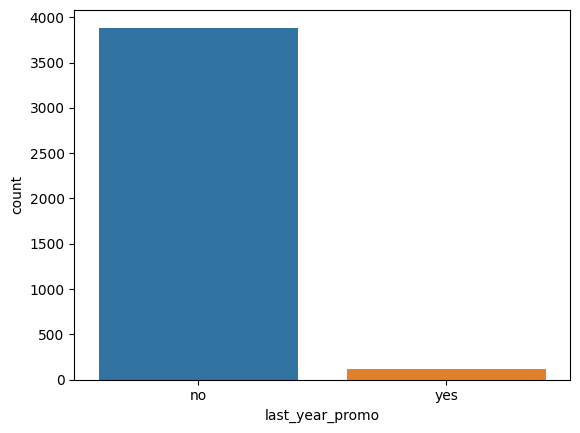

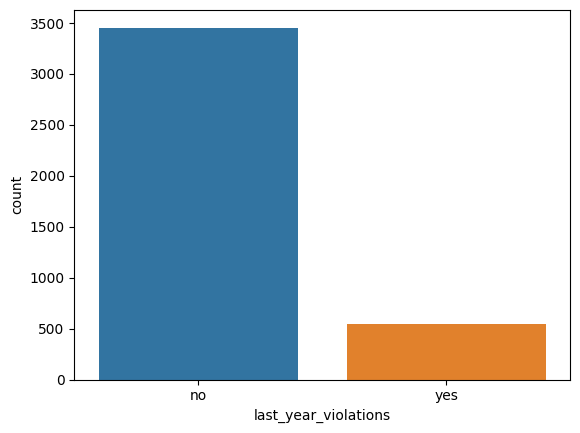

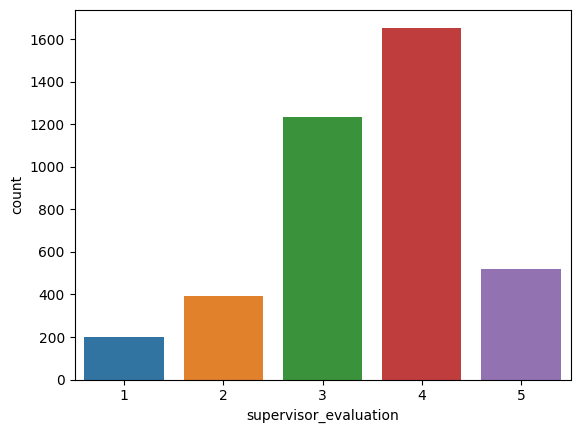

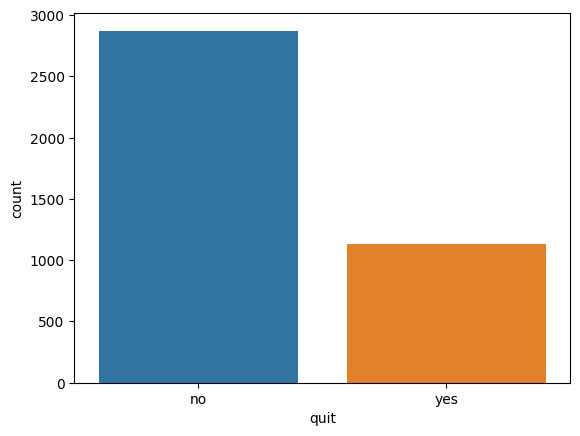

In [67]:
for i in train_quit.select_dtypes(exclude='number').columns:
    sns.countplot(data=train_quit, x=i)
    plt.show()

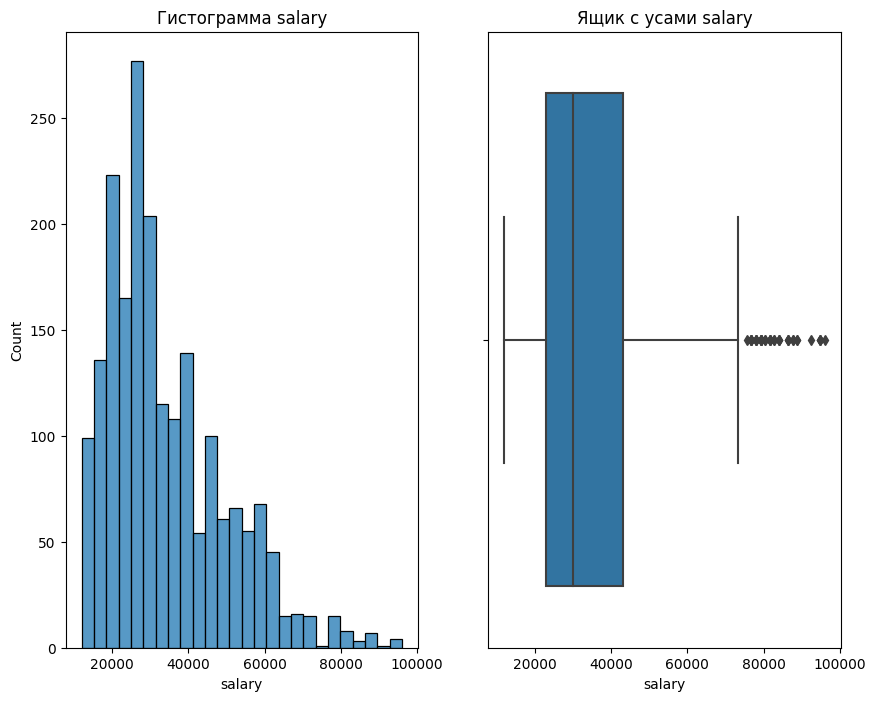

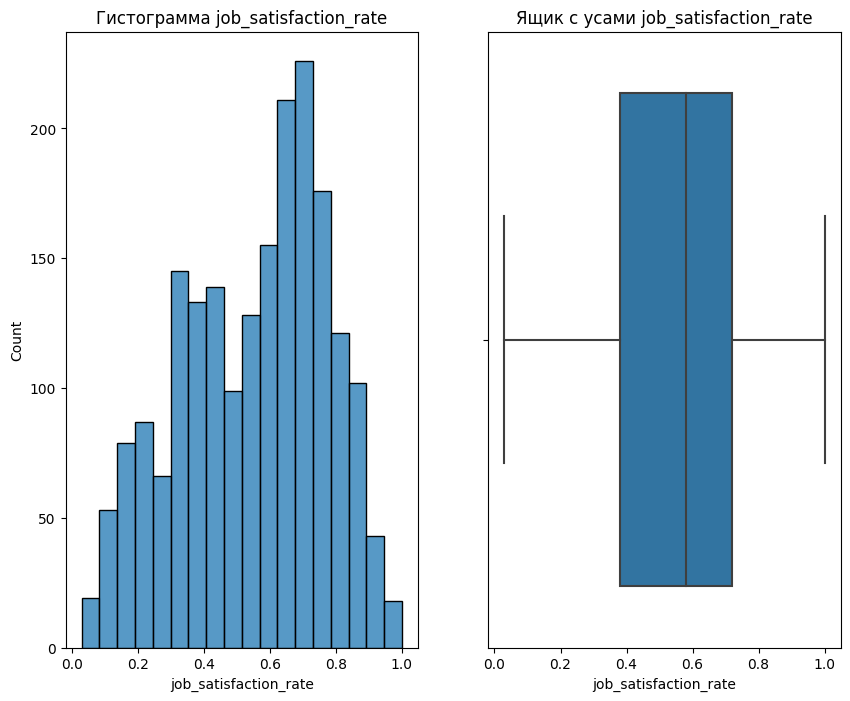

In [68]:
for i in full_test_features.drop(['employment_years'], axis=1).select_dtypes(include='number').columns:
    fig, axes = plt.subplots(1, 2, figsize=(10, 8))
    sns.histplot(data=full_test_features, x=i, ax=axes[0])
    axes[0].set_title(f'Гистограмма {i}')
    sns.boxplot(data=full_test_features, x=i, ax=axes[1])
    axes[1].set_title(f'Ящик с усами {i}')

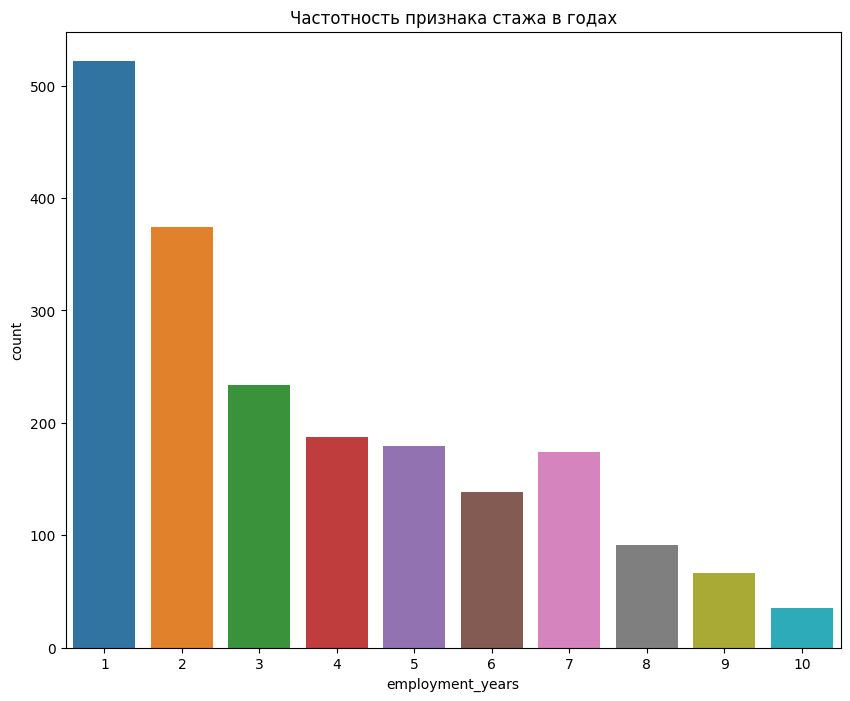

In [69]:
plt.figure(figsize=(10, 8))
sns.countplot(data=full_test_features, x='employment_years');
plt.title('Частотность признака стажа в годах')
plt.show()

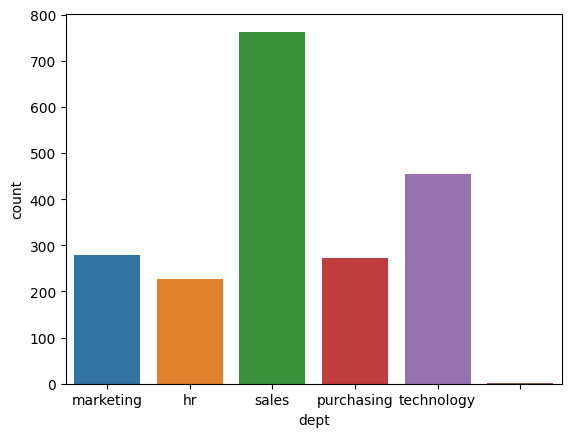

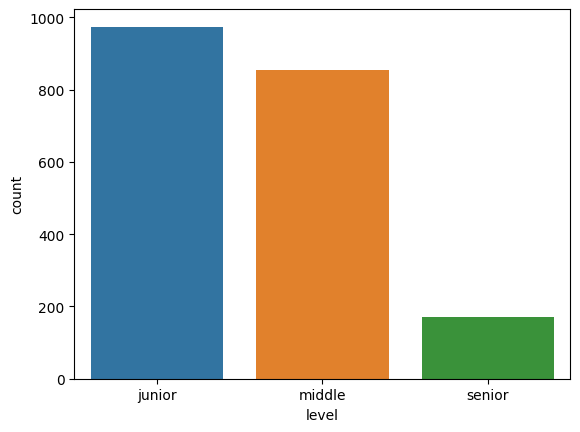

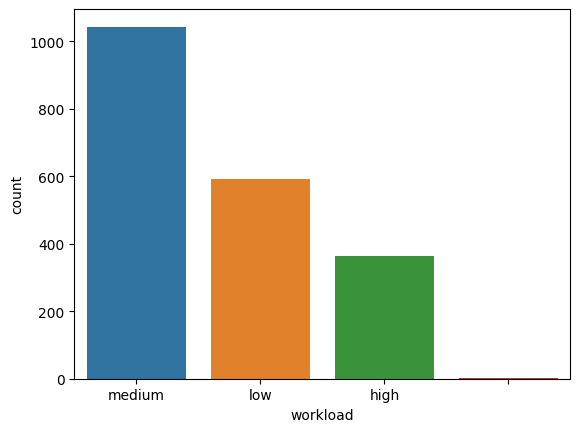

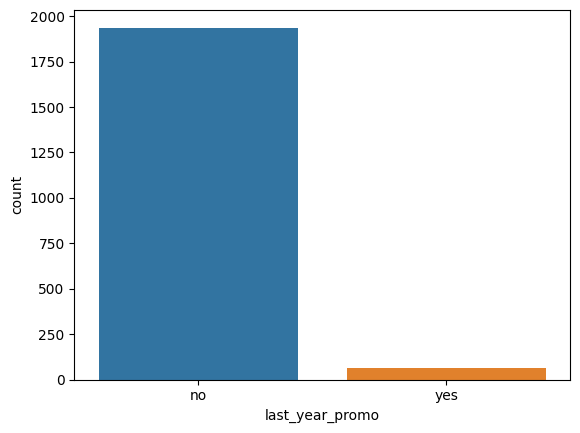

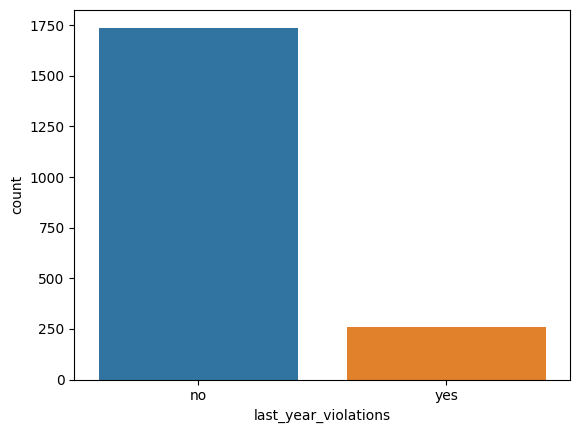

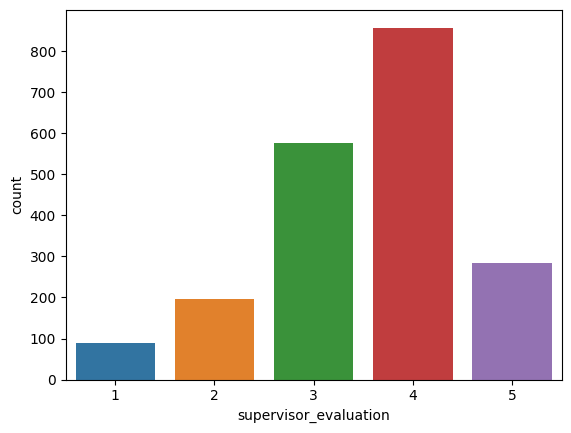

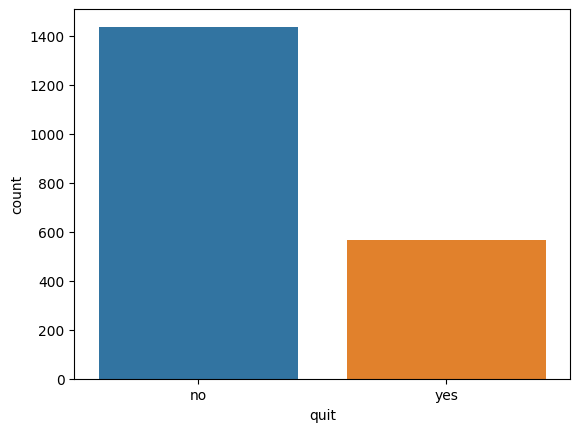

In [70]:
for i in full_test_features.select_dtypes(exclude='number').columns:
    sns.countplot(data=full_test_features, x=i)
    plt.show()

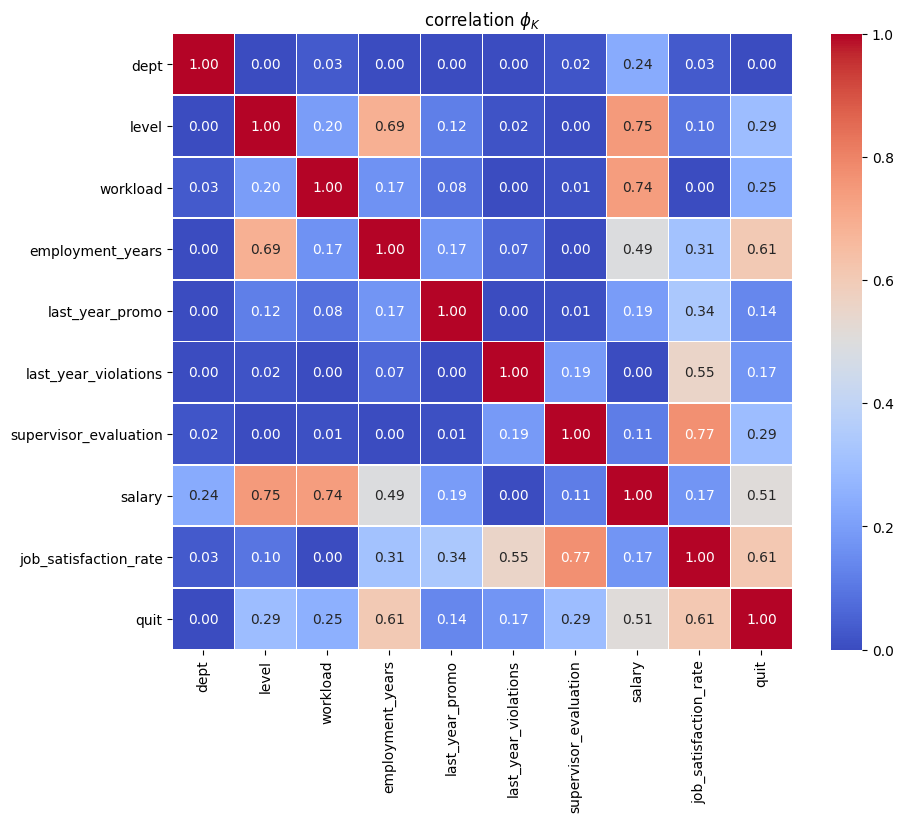

In [71]:
interval_cols = full_test_features.select_dtypes(include='number').columns.to_list()

plt.figure(figsize=(10, 8))
sns.heatmap(full_test_features.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5);

plt.title(r"correlation $\phi_K$")
plt.show()

#### 3.2 Анализ портрета «уволившегося сотрудника»

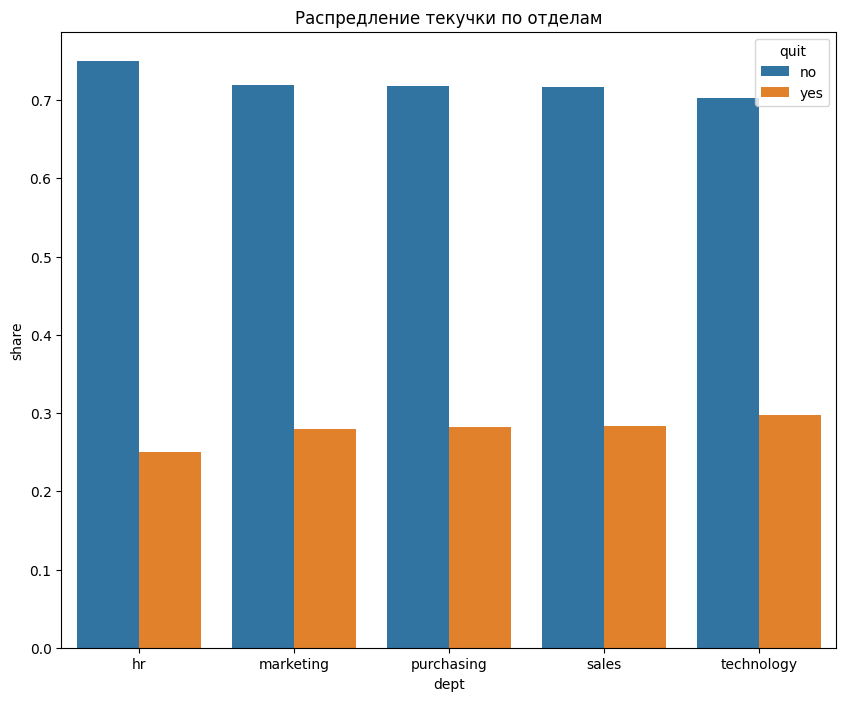

In [72]:
dept_grouped = train_quit.groupby(['dept'])['quit'].value_counts(normalize=True).rename('share').reset_index()
plt.figure(figsize=(10, 8))
plt.title('Распредление текучки по отделам')
sns.barplot(data=dept_grouped, x='dept', y='share', hue='quit')
plt.show()

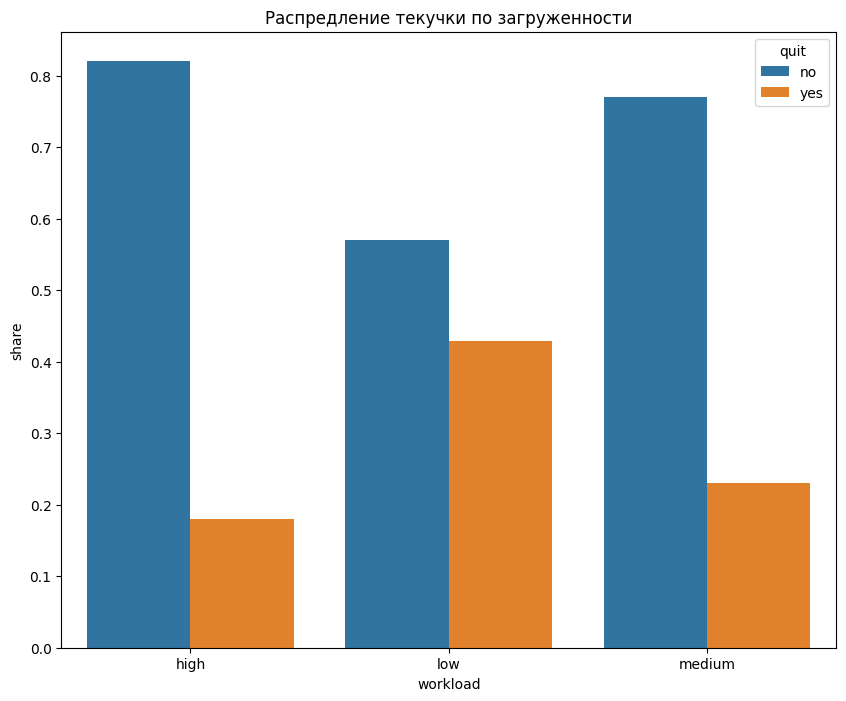

In [73]:
workload_grouped = train_quit.groupby(['workload'])['quit'].value_counts(normalize=True).rename('share').reset_index()
plt.figure(figsize=(10, 8))
plt.title('Распредление текучки по загруженности')
sns.barplot(data=workload_grouped, x='workload', y='share', hue='quit')
plt.show()

In [74]:
train_quit.pivot_table(values='salary', index='quit', aggfunc='mean')

,salary
quit,
no,37702.228412
yes,23885.106383


Если рассматривать по доле, то больше всего уволившихся в разрезе департамента - это департамент технологий, а в разрезе загрузки - это низкая загруженность.

У тех кто уволились средняя зарплата на 14тыс меньше

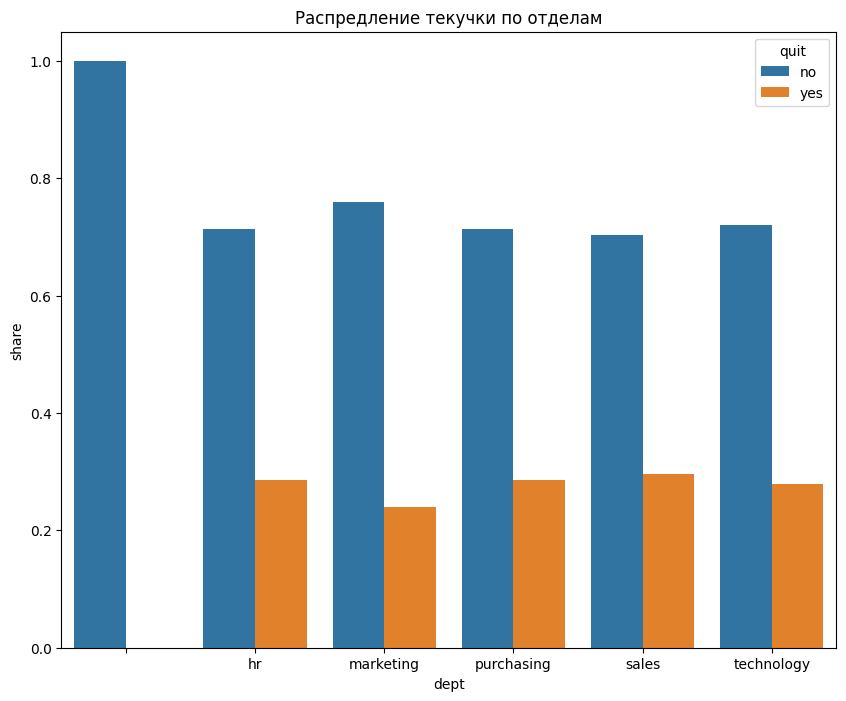

In [75]:
dept_grouped = full_test_features.groupby(['dept'])['quit'].value_counts(normalize=True).rename('share').reset_index()
plt.figure(figsize=(10, 8))
plt.title('Распредление текучки по отделам')
sns.barplot(data=dept_grouped, x='dept', y='share', hue='quit')
plt.show()

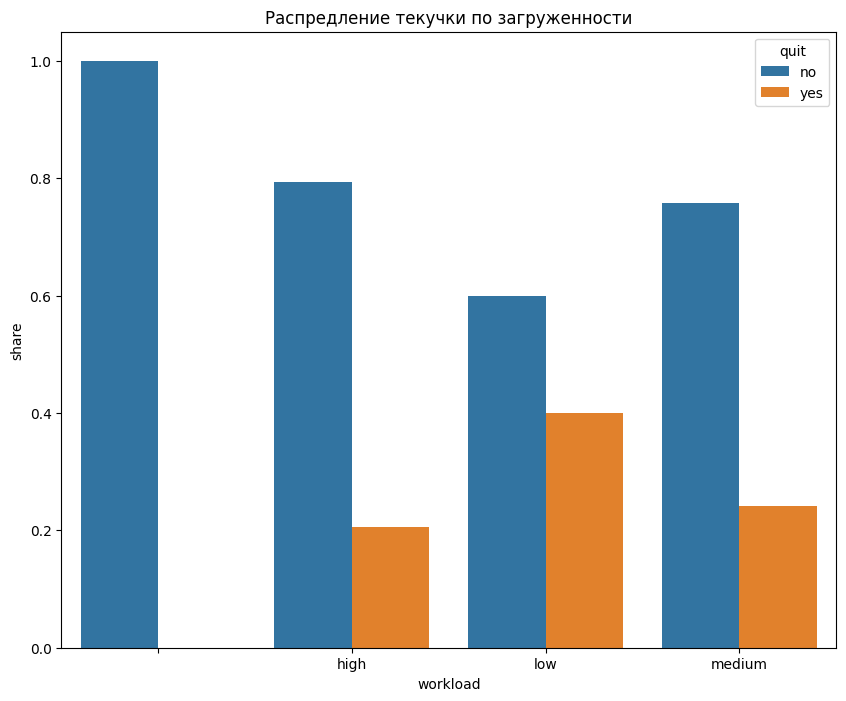

In [76]:
workload_grouped = full_test_features.groupby(['workload'])['quit'].value_counts(normalize=True).rename('share').reset_index()
plt.figure(figsize=(10, 8))
plt.title('Распредление текучки по загруженности')
sns.barplot(data=workload_grouped, x='workload', y='share', hue='quit')
plt.show()

In [77]:
full_test_features.pivot_table(values='salary', index='quit', aggfunc='mean')

,salary
quit,
no,37645.403900
yes,24955.319149


В тестовых данных совсем немного другая ситуация. Преобладает отдел продаж, по загруженности тоже самое. Разница зарплат примерно та же.
Единственное из за пробелов в данных идет небольшое искажение.

#### 3.3 Анализ уровня удовлетворенности сотрудника

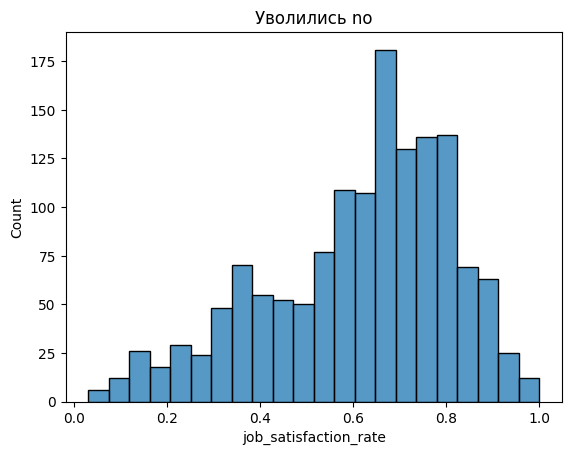

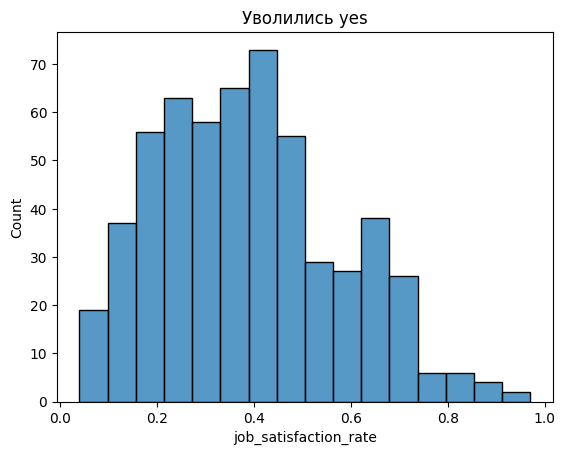

In [78]:
for i in ['no', 'yes']:    
    sns.histplot(full_test_features[full_test_features['quit'] == i], x='job_satisfaction_rate')
    plt.title(f'Уволились {i}')
    plt.show()

Видим что пик гистограммы тех, кто не уволился стремится к более высоким значениям удовлетворенности сотрудников, чем у тех, кто уволился.

### 4. Добавление входного признака job_satisfaction_rate

In [79]:
print(train_job_satisfaction_rate.drop('job_satisfaction_rate', axis=1).columns.to_list() == train_quit.drop('quit', axis=1).columns.to_list())

True


In [80]:
train_quit_pred = oscv_rfr.best_estimator_.predict(train_quit.drop('quit', axis=1)) # type: ignore
train_quit_pred

array([0.64217449, 0.84609191, 0.41146608, ..., 0.55796324, 0.52129562,
       0.52518611])

In [81]:
train_quit['job_satisfaction_rate'] = train_quit_pred
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.642174
814010,sales,junior,medium,2,no,no,4,27600,no,0.846092
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.411466
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.327973
910140,marketing,junior,medium,2,no,no,5,25200,no,0.790568


In [82]:
full_test_features = full_test_features.drop('job_satisfaction_rate', axis=1)
full_test_features_pred = oscv_rfr.best_estimator_.predict(full_test_features.drop('quit', axis=1)) # type: ignore
full_test_features['job_satisfaction_rate'] = full_test_features_pred
display(full_test_features.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no,0.863101
686555,hr,junior,medium,1,no,no,4,30000,no,0.680256
467458,sales,middle,low,5,no,no,4,19200,no,0.667042
418655,sales,middle,low,6,no,no,4,19200,no,0.670346
789145,hr,middle,medium,5,no,no,5,40800,no,0.808461


### 5. Подготовка данных и обучение моделей

In [83]:
print(f'Количество явных дубликатов после отнесения id к индексу в датафрейме train quit {train_quit.duplicated().sum()}')
print(f'Количество явных дубликатов после отнесения id к индексу в датафрейме full test features {full_test_features.duplicated().sum()}')

Количество явных дубликатов после отнесения id к индексу в датафрейме train quit 1413
Количество явных дубликатов после отнесения id к индексу в датафрейме full test features 504


In [84]:
X_train_quit, y_train_quit = train_quit.drop('quit', axis=1), train_quit['quit']
X_test_quit, y_test_quit = full_test_features.drop('quit', axis=1), full_test_features['quit']

In [85]:
display(X_train_quit.head())
display(X_test_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.642174
814010,sales,junior,medium,2,no,no,4,27600,0.846092
155091,purchasing,middle,medium,5,no,no,1,37200,0.411466
257132,sales,junior,medium,2,no,yes,3,24000,0.327973
910140,marketing,junior,medium,2,no,no,5,25200,0.790568


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.863101
686555,hr,junior,medium,1,no,no,4,30000,0.680256
467458,sales,middle,low,5,no,no,4,19200,0.667042
418655,sales,middle,low,6,no,no,4,19200,0.670346
789145,hr,middle,medium,5,no,no,5,40800,0.808461


In [86]:
label_encoder = LabelEncoder()
y_train_quit_lbl = label_encoder.fit_transform(y_train_quit)
y_test_quit_lbl = label_encoder.transform(y_test_quit)

In [87]:
label_encoder.classes_

array(['no', 'yes'], dtype=object)

'no' у нас закодировалось как 0, 'yes' как 1

In [88]:
def optuna_search_cat(pipe, param_grid, n_trials=25):
    oscv = OptunaSearchCV(
        pipe,
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_trials=n_trials,
        random_state=RANDOM_STATE,
        error_score='raise'
    ).fit(X_train_quit, y_train_quit_lbl)


    print(f'Метрика лучшей модели: {oscv.best_score_:.3f}')
    print(f'Параметры лучшей модели: {oscv.best_params_}')
   
    return oscv.best_estimator_

#### 5.1 SVC

In [89]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload', 'supervisor_evaluation']
num_columns = X_train_quit.select_dtypes(include='number').columns.to_list()

data_preprocessor_linear = ColumnTransformer(
    [
        ('ohe', ohe_pipe_linear, ohe_columns),
        ('ord', ord_pipe_linear, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final_linear_svc = Pipeline(
    [
        ('preprocessor', data_preprocessor_linear),
        ('models', SVC(probability=True, random_state=RANDOM_STATE))
    ]
)    
    
    
param_grid_linear_svc = {
    'models__kernel': distributions.CategoricalDistribution(['rbf', 'linear', 'sigmoid']),
    'models__C': distributions.FloatDistribution(1, 10, step=0.5),
    'preprocessor__num': distributions.CategoricalDistribution([
        MinMaxScaler(), 
        StandardScaler(), 
        RobustScaler(),
    ])
}

In [90]:
%%time

oscv_svc_cat = optuna_search_cat(pipe_final_linear_svc, param_grid_linear_svc)

[I 2025-06-13 18:57:23,902] A new study created in memory with name: no-name-e3e8365d-8908-4e3c-98cc-dfe9a23c8dab
[I 2025-06-13 18:57:28,652] Trial 0 finished with value: 0.9145229221340528 and parameters: {'models__kernel': 'linear', 'models__C': 4.0, 'preprocessor__num': MinMaxScaler()}. Best is trial 0 with value: 0.9145229221340528.
[I 2025-06-13 18:57:33,977] Trial 1 finished with value: 0.610710347101844 and parameters: {'models__kernel': 'sigmoid', 'models__C': 4.0, 'preprocessor__num': MinMaxScaler()}. Best is trial 0 with value: 0.9145229221340528.
[I 2025-06-13 18:57:37,776] Trial 2 finished with value: 0.8466379523379031 and parameters: {'models__kernel': 'sigmoid', 'models__C': 10.0, 'preprocessor__num': StandardScaler()}. Best is trial 0 with value: 0.9145229221340528.
[I 2025-06-13 18:57:42,184] Trial 3 finished with value: 0.9285102780500019 and parameters: {'models__kernel': 'rbf', 'models__C': 5.0, 'preprocessor__num': StandardScaler()}. Best is trial 3 with value: 0.9

Метрика лучшей модели: 0.931
Параметры лучшей модели: {'models__kernel': 'rbf', 'models__C': 7.0, 'preprocessor__num': MinMaxScaler()}
CPU times: total: 2min
Wall time: 2min 1s


#### 5.2 KNeighborsClassifier

In [91]:
pipe_final_knc = Pipeline(
    [
        ('preprocessor', data_preprocessor_linear),
        ('models', KNeighborsClassifier(n_jobs=-1))
    ]
)    
    
    
param_grid_knc = {
    'models__n_neighbors': distributions.IntDistribution(5, 20),
    'preprocessor__num': distributions.CategoricalDistribution([
        MinMaxScaler(), 
        StandardScaler(), 
        RobustScaler(),
    ])
}

In [92]:
%%time

oscv_knn_cat = optuna_search_cat(pipe_final_knc, param_grid_knc)

[I 2025-06-13 18:59:25,536] A new study created in memory with name: no-name-c3594e99-b49e-4980-88c9-064c79c9d852
[I 2025-06-13 18:59:25,886] Trial 0 finished with value: 0.9193000213578676 and parameters: {'models__n_neighbors': 12, 'preprocessor__num': MinMaxScaler()}. Best is trial 0 with value: 0.9193000213578676.
[I 2025-06-13 18:59:26,240] Trial 1 finished with value: 0.9193000213578676 and parameters: {'models__n_neighbors': 12, 'preprocessor__num': MinMaxScaler()}. Best is trial 0 with value: 0.9193000213578676.
[I 2025-06-13 18:59:26,566] Trial 2 finished with value: 0.9226839839915796 and parameters: {'models__n_neighbors': 7, 'preprocessor__num': RobustScaler()}. Best is trial 2 with value: 0.9226839839915796.
[I 2025-06-13 18:59:26,945] Trial 3 finished with value: 0.9250773991187831 and parameters: {'models__n_neighbors': 13, 'preprocessor__num': RobustScaler()}. Best is trial 3 with value: 0.9250773991187831.
[I 2025-06-13 18:59:27,360] Trial 4 finished with value: 0.9193

Метрика лучшей модели: 0.928
Параметры лучшей модели: {'models__n_neighbors': 15, 'preprocessor__num': StandardScaler()}
CPU times: total: 15 s
Wall time: 8.99 s


#### 5.3 RandomForestClassifier

In [93]:
ordered_features = ['level', 'workload', 'supervisor_evaluation']
unordered_features = ['dept', 'last_year_promo', 'last_year_violations']
num_features = X_train_quit.select_dtypes(include='number').columns.to_list()

data_preprocessor_rfc = ColumnTransformer(
    [
        ('ord_ordered', ordered_pipe_rfr, ordered_features),
        ('ord_unordered', unordered_pipe_rfr, unordered_features),
    ],
    remainder='passthrough'
)

pipe_final_rfc = Pipeline(
    [
        ('preprocessor', data_preprocessor_rfc),
        ('models', RandomForestClassifier(random_state=RANDOM_STATE))
    ]
)    
    
    
param_grid_rfc = {
    'models__n_estimators': distributions.IntDistribution(100, 150),
    'models__criterion': distributions.CategoricalDistribution(['gini', 'entropy']),
    'models__max_depth': distributions.IntDistribution(1, 100),
    'models__min_samples_split': distributions.IntDistribution(2, 50),
    'models__min_samples_leaf': distributions.IntDistribution(1, 50),
}

In [94]:
%%time

oscv_rfc_cat = optuna_search_cat(pipe_final_rfc, param_grid_rfc)

[I 2025-06-13 18:59:34,598] A new study created in memory with name: no-name-de6bb1e6-0c74-4f28-83a5-849c19683603
[I 2025-06-13 18:59:36,486] Trial 0 finished with value: 0.9364566966805927 and parameters: {'models__n_estimators': 123, 'models__criterion': 'gini', 'models__max_depth': 32, 'models__min_samples_split': 25, 'models__min_samples_leaf': 15}. Best is trial 0 with value: 0.9364566966805927.
[I 2025-06-13 18:59:38,279] Trial 1 finished with value: 0.9324819165178185 and parameters: {'models__n_estimators': 110, 'models__criterion': 'entropy', 'models__max_depth': 32, 'models__min_samples_split': 19, 'models__min_samples_leaf': 50}. Best is trial 0 with value: 0.9364566966805927.
[I 2025-06-13 18:59:40,129] Trial 2 finished with value: 0.9325037752958082 and parameters: {'models__n_estimators': 125, 'models__criterion': 'entropy', 'models__max_depth': 48, 'models__min_samples_split': 43, 'models__min_samples_leaf': 49}. Best is trial 0 with value: 0.9364566966805927.
[I 2025-06

Метрика лучшей модели: 0.938
Параметры лучшей модели: {'models__n_estimators': 130, 'models__criterion': 'gini', 'models__max_depth': 86, 'models__min_samples_split': 35, 'models__min_samples_leaf': 6}
CPU times: total: 45.5 s
Wall time: 46 s


Все рассмотренные модели получили метрику roc_auc выше 0,91. Лучше всего с задачей, судя по метрике справляется, RandomForestClassifier. Метрика ROC_AUC равна примерно 0.924.

In [95]:
metric_roc_auc = roc_auc_score(y_test_quit_lbl, 
                               oscv_rfc_cat.predict_proba(X_test_quit)[:,1] # type: ignore
                               )

print(f'ROC AUC лучшей модели на тестовой выборке {metric_roc_auc:.3f}')

ROC AUC лучшей модели на тестовой выборке 0.929


#### 6.1 Анализ важности признаков для лучшей модели

In [96]:
def custom_shap(model_pipe, X):
    """
    выводит график shap summary plot
    """
    X_transformed_shap = pd.DataFrame(
    model_pipe.named_steps['preprocessor'].transform(X), 
    columns=model_pipe.named_steps['preprocessor'].get_feature_names_out()
    )
    model = model_pipe.named_steps['models']

    #Определяем Explainer и находим shape values
    explainer = shap.Explainer(model.predict, X_transformed_shap, feature_names=X_transformed_shap.columns)
    shap_values = explainer(X_transformed_shap)

    #Строим график
    shap.summary_plot(shap_values, X_transformed_shap, feature_names=X_transformed_shap.columns, plot_size=(12, 6))

ExactExplainer explainer: 2001it [08:25,  3.91it/s]                          


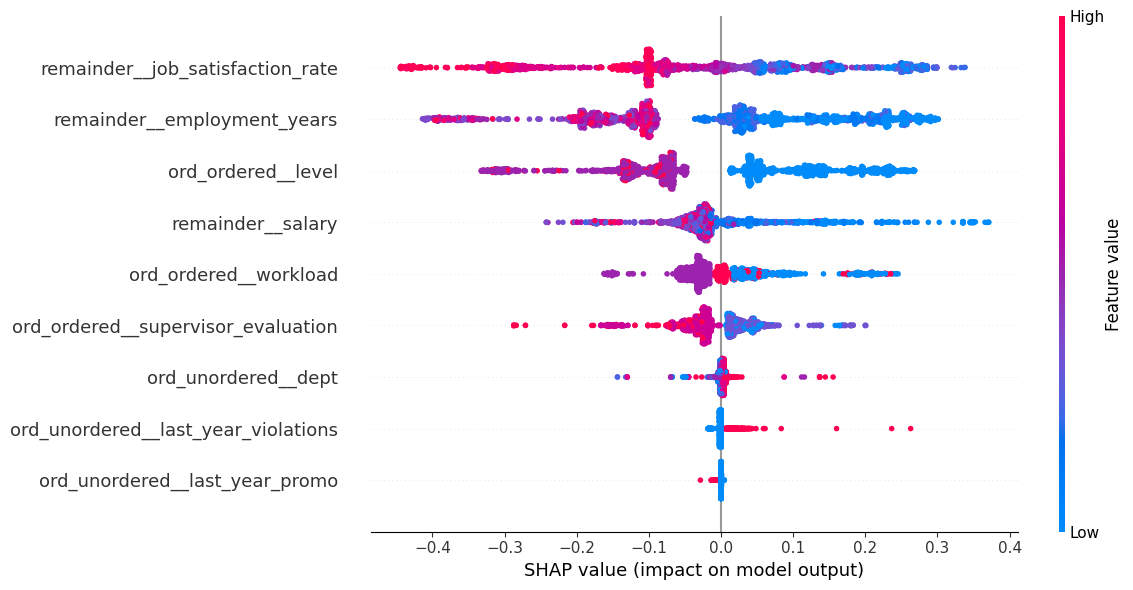

In [97]:
custom_shap(oscv_rfc_cat, X_test_quit) # type: ignore

Три наиболее важных признака модель определяет такие как: уровень должности, количество проработанных лет и уровень удовлетворенности. Наименее важные признаки для модели: были ли нарушения в прошлом году, департмент и были ли повышения в прошлом году.<br>
Судя по графику можем отметить тот факт, что для модели более низкие значения в уровне занимаемой должности склоняет её предсказания в сторону того, что сотрудник уволится. То же самое с количеством проработанных лет. Что косатеся уровня удовлетворенности работой сторудников, то в этом признаке лучше всего прослеживается краснота, что говорит о том, что при высоких значениях этого признака модель склоняется к тому, что сотрудник не уволится. Также краснота премущественно преобладает у признаков ЗП и оценки проверяющего и модель их относит к тому, что сотрудник не уволится. И сильно выраженная синева, низкие значения, у ЗП на графике склоняет предсказание модели к тому, что сотрудник уволится

### Общий вывод

**Общий вывод**<br>
1. Были проверены данные на наличие дубликатов, пропусков и опечаток. Все необходимые изменения проделаны
2. Проведен исследовательский анализ данных. Было обнаружены выбросы по признаку salary, что говорит о том, что наблюдается небольшое кол-во сотрудников с более высокой зарплатой, чем большинство остальных. В этой компании преобладают сотрудники со стажом 1-2 года. Больше всего уволившихся в разрезе департамента - это департамент технологий/продаж, а в разрезе загрузки - это низкая загруженность. В среднем зарплата уволивших меньше остальных на 13-14 тыс. Исходя из графиков уровень удовлетворенности сотрудников, которые не уволились, выше, чем у тех, кто уволился.
3. Были обучены и определены лучшие модели. Для обоих случаев это модели случайного леса. Также для задачи классификации был добавлен входной признак удовлетворенности сотрудника с помощью предсказаний лучшей модели из первой задачи.
4. Была проанализирована важность признаков для каждой выбранной модели:<br>
RandomForestRegressor: наиболее важный признак для модели является загруженность работника. Далее идет оценка проверяющим и заробатная плата. Самым незначительным признаком модель определила было ли повышение в прошлом году.<br>
RandomForestClassifier: Три наиболее важных признака модель определяет такие как: уровень должности, количество проработанных лет и уровень удовлетворенности. Наименее важные признаки для модели: были ли нарушения в прошлом году, департмент и были ли повышения в прошлом году.<br>
Для модели более низкие значения в уровне занимаемой должности склоняет её предсказания в сторону того, что сотрудник уволится. То же самое с количеством проработанных лет. При высоких значениях этого признака удовлетворенности сотрудника модель склоняется к тому, что сотрудник не уволится. Также краснота премущественно преобладает у признаков ЗП и оценки проверяющего и модель их относит к тому, что сотрудник не уволится. И сильно выраженная синева, низкие значения, у ЗП на графике склоняет предсказание модели к тому, что сотрудник уволится
